# Overview

### Goal

The objective of this notebook is to build a model to classify images of animals.

### Data

The dataset used to train and test our models is the [Animals-10 dataset](https://www.kaggle.com/datasets/alessiocorrado99/animals10) (available on Kaggle): a collection of photographs of various animals. The images are stored as jpeg files and organized in subfolders by class, i.e., the animal depicted in the image (note, the folder names are in Italian). The dataset contains roughly 25,000 images, 10 unique classes, and are unbalanced with respect to the classes (this was verified in the corresponding data exploration notebook).

### Model

The model is a Convolutional Neural Network (CNN) trained on a subset of the data. Some of the model's hyperparameters are tuned and the best model is selected for testing on a disjoint subset to the training set.

# Environment setup

Start by importing the libraries we'll need for this analysis. The key libraries are:

* `pandas` and `numpy` for light data analysis, side studies, model evaluation
* `matplotlib` and `seaborn` for plots and visualizations
* `sklearn` to split the data into training, validation, and testing sets
* `torch` and `torchvision` for loading and storaing image data, model implementation, training, and evaluation
* `torchmetrics` for computing training/testing metrics (e.g., accuracy)
* `ray` for hyperparameter tuning

In [1]:
import os
import time
import tempfile
from collections import defaultdict
from functools import partial
from IPython.core.interactiveshell import InteractiveShell
from tqdm.notebook import tqdm 

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
from torch import Generator
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler

import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2

from torchmetrics.classification import MulticlassAccuracy, MulticlassConfusionMatrix

import ray
from ray import tune
from ray import train
from ray.tune import Tuner, TuneConfig
from ray.tune.schedulers import ASHAScheduler
from ray.train import Checkpoint, get_checkpoint, RunConfig
from ray.train.torch import TorchTrainer

2024-07-02 22:48:17,250	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-07-02 22:48:17,763	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-07-02 22:48:18,187	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Initialize a few settings here to make life easier.

In [2]:
# Displays all commands in a cell
InteractiveShell.ast_node_interactivity = 'all'

# Progress bar with pandas 'apply'
tqdm.pandas()

# Plot aesthetics
sns.set_style('darkgrid')
my_palette = ['#D62828','#003049','#1B998B','#F77F00','#FCBF49','#EAE2B7','#6E9075','#EFBDEB','#F0F757','#777DA7']
sns.set_palette(my_palette, n_colors=10)

# Random seeds for reproducibility
SEED_1 = 12
SEED_2 = 24
SEED_3 = 48
torch.manual_seed(SEED_1);

PyTorch tensors and models can be loaded onto the GPU for fast training. Check if a GPU is availible and set the device to the availible computing resource.

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Read data

In [4]:
# Define input/output paths
RAW_DATA_PATH = '/kaggle/input/animals10/raw-img/'
OUT_PATH = '/kaggle/working/'

# Save all figures to this directory
FIGURE_PATH = os.path.join(OUT_PATH, 'figures')
if not os.path.exists(FIGURE_PATH):
    os.mkdir(FIGURE_PATH)

Create a data loader with `ImageFolder` for accessing the image and label data (designed to read images separated into folders by class), and apply transforms to each image. The transforms ensure each image we load is in the same format and the same size. We also apply four random data augmentations (e.g., rotations, flips, or hue adjustments) that will allow us to oversample from this dataset without redundancy, effectively increasing the size of our dataset. This is especially important when we balance the classes in the dataset. 

More about data augmentation here: https://en.wikipedia.org/wiki/Data_augmentation

For a list of the augmentations applied by `RandAugment` from `torchvision` see: https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_illustrations.html

In [5]:
IMAGE_SIZE = 300
NUM_AUGS = 4
AUG_MAG = 9

my_transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.uint8, scale=True),
    v2.CenterCrop(IMAGE_SIZE),
    v2.RandAugment(num_ops=NUM_AUGS, magnitude=AUG_MAG),
    v2.ToDtype(torch.float32, scale=True)
])

dataset = ImageFolder(root=RAW_DATA_PATH, transform=my_transforms)

In [6]:
# Since animal names are in Italian we will have to translate into English
dataset.class_to_idx
translate = {
    'cane': 'Dog', 
    'cavallo': 'Horse', 
    'elefante': 'Elephant', 
    'farfalla': 'Butterfly', 
    'gallina': 'Chicken', 
    'gatto': 'Cat', 
    'mucca': 'Cow', 
    'pecora': 'Sheep', 
    'ragno': 'Spider', 
    'scoiattolo': 'Squirrel'
}
idx_to_label = {idx: translate[class_ita] for class_ita, idx in dataset.class_to_idx.items()}

{'cane': 0,
 'cavallo': 1,
 'elefante': 2,
 'farfalla': 3,
 'gallina': 4,
 'gatto': 5,
 'mucca': 6,
 'pecora': 7,
 'ragno': 8,
 'scoiattolo': 9}

Quickly validate that the images are loaded properly and the random augmentation is correctly applied by plotting a batch of images.

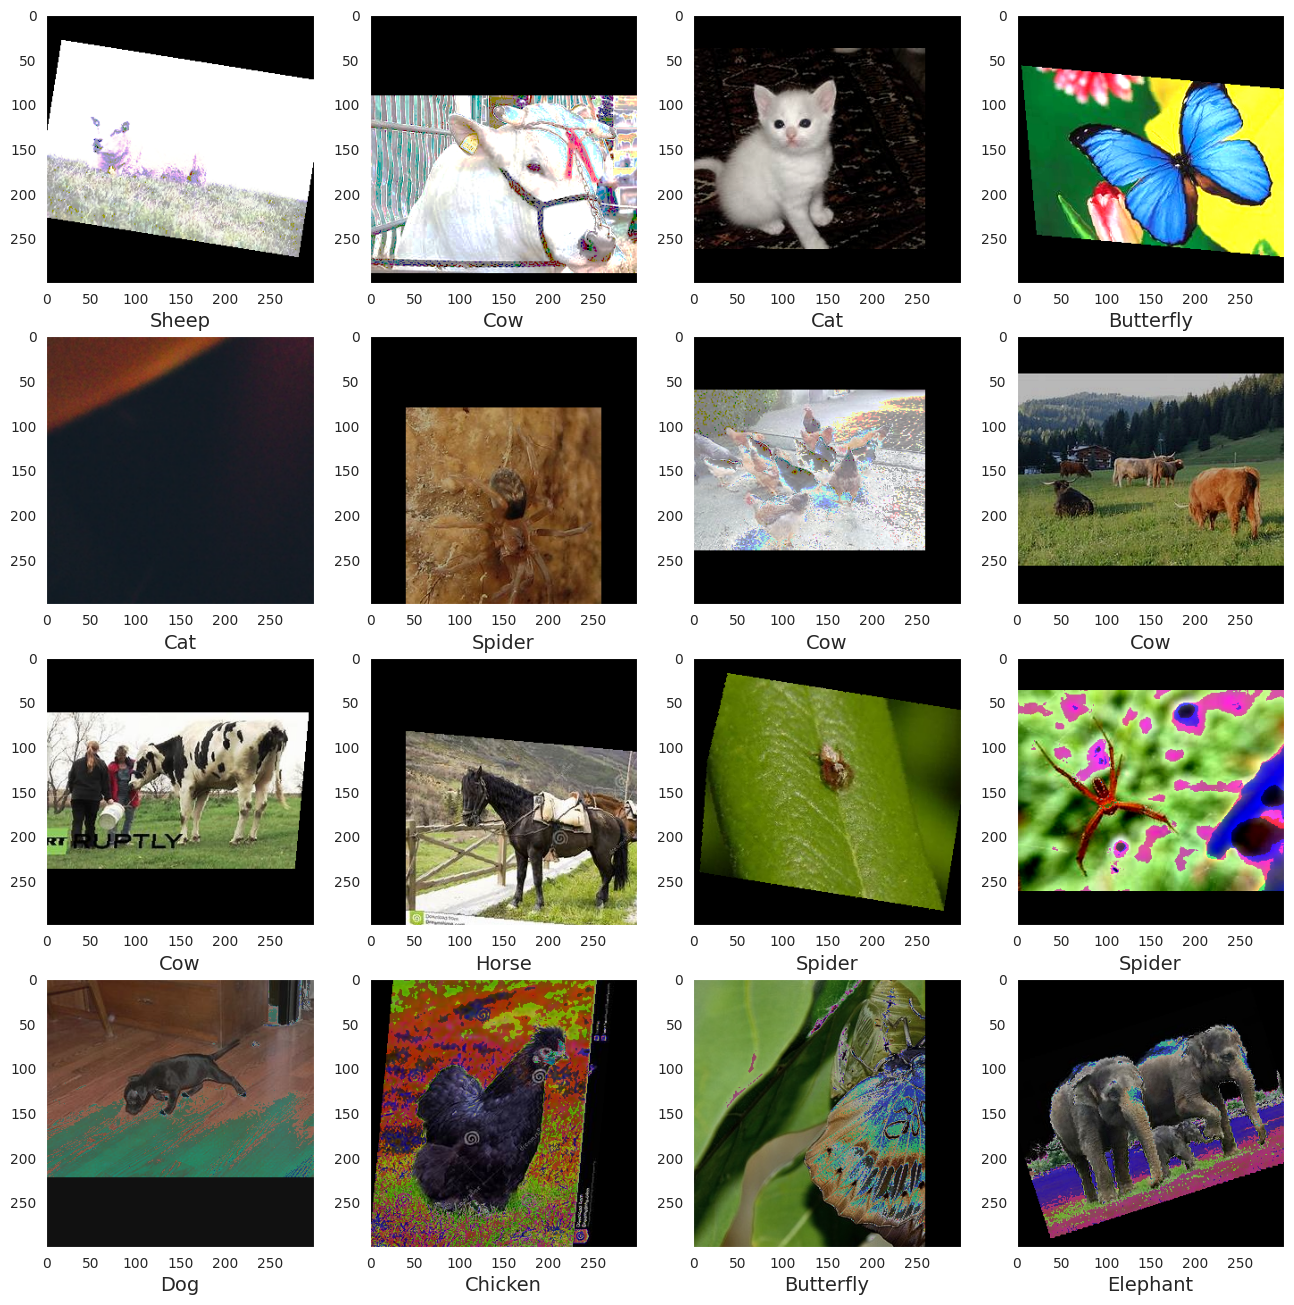

In [7]:
# DataLoader to check a few images - not used for analysis
tmp_loader = DataLoader(dataset, shuffle=True, generator=Generator('cpu').manual_seed(SEED_1))

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(16,16))
for row in range(4):
    for col in range(4):
        features, labels = next(iter(tmp_loader))
        
        # Tensors are of dimension (channel, width, height) but to plot we need (width, height, channel), so permute the dimensions
        ax[row, col].imshow(features[0].permute(1, 2, 0))
        
        # Clean up images
        ax[row, col].grid(False)
        ax[row, col].set_xlabel(idx_to_label[labels[0].item()], size=14)
        
plt.savefig(os.path.join(FIGURE_PATH,'augmented-image-sample.pdf'), bbox_inches='tight');

# Split data

The bulk of our data will be used to train our model, but we will need to dedicate some images to test the model that are not used in the training set. To evaluate the performance of our model during training and tune the hyperparameters we will also split a validation set off of our training set. 

We randomly sample indices from the entire dataset, splitting data into non-overlapping training, validation, and testing sets with `train_test_split` from the `sklearn` library. To guarantee validation and testing sets are representative of the training set, we use stratified sampling, which first divides data into classes and then splits the data (by random sampling) into the subsets inside each class.

More on stratified sampling here: https://en.wikipedia.org/wiki/Stratified_sampling

The result is three lists of indices (one for each test/val/train set) to be passed to each data loader, which will tell the loader to only sample those indicies from our dataset. A popular training/validation/testing split of 60/20/20 is used.

In [8]:
TEST_SPLIT = 0.2 # Split 20% off dataset for testing, 80% of training + validation
VAL_SPLIT = 0.25 # Split 25% off remaining 80% for validation, yielding 60% for training, 20% for validation

# Indices will be passed to data loaders, telling loaders to only sample from those indices of the dataset 
train_idx, test_idx = train_test_split(
    np.arange(len(dataset.targets)),
    test_size=TEST_SPLIT,
    random_state=SEED_1, 
    shuffle=True, 
    stratify=dataset.targets
)
train_idx, val_idx = train_test_split(
    train_idx,          
    test_size=VAL_SPLIT,
    random_state=SEED_2,
    shuffle=True,
    stratify=[dataset.targets[idx] for idx in train_idx]
)

In [9]:
# Inspect the train/val/test sets
len(train_idx)
len(val_idx)
len(test_idx)

# Check each split is the right proportion
len(train_idx)/len(dataset.targets)
len(val_idx)/len(dataset.targets)
len(test_idx)/len(dataset.targets)

# Check that all indices are unique
len(train_idx) == len(set(train_idx))
len(val_idx) == len(set(val_idx))
len(test_idx) == len(set(test_idx))

# Check that no sets overlap
(set(train_idx) & set(val_idx)) == set()
(set(train_idx) & set(test_idx)) == set()
(set(val_idx) & set(test_idx)) == set()

15707

5236

5236

0.5999847205775621

0.2000076397112189

0.2000076397112189

True

True

True

True

True

True

# Balance classes

As seen in the exploratory notebook, the dataset is strongly imbalanced, with dog and spider categories heavily over-represented. Training a model on an imbalanced dataset will result in strong bias toward the majority classes--which is undesireable in our case. 

### SMOTE
To suppress training bias in our model, we will *over-sample* the minority classes and *under-sample* the majority classes, such that the number of images in each class used to train and evaluate our model are approximately equal. However, just over-sampling with replacement (i.e., training the model on the same image multiple times) naturally leads to overfitting as the model learns to place a greater weight on the specific features of any duplicated images. Applying data augmentation to each image, we can generate as many new "synthetic" samples for a given class as we need that train our model to discriminate on more general features. Combining minority over-sampling with data augmentation accomplishes our goal of a balanced dataset and prevents overfitting from replication. This approach is called Sythetic Minority Over-sampling TEchnique (SMOTE) and is a popular method for training classifiers on imbalanced datasets.

More on SMOTE here: https://arxiv.org/pdf/1106.1813

The way we will over/under-sample each class is by using weighted sampling (larger weights = higher probability of being sampled). The functions below determine the weight needed for each class to balance the dataset, then assigns the corresponding weight to each index in the dataset. The result is a `WeightedRandomSampler` object that can be passed to a data loader for a given training, validation, or testing set. 

In [10]:
def balanced_class_weights(targets, subset_idx):
    '''Return the per-class weights needed to balance the class distributions.
    
    Each class's weight is defined as the reciprical of the class's count in the subset.
    When data are sampled from each subset with these weights, the class distribution will
    be approximately balanced for a sufficiently large sample.
    '''
    subset_idx = set(subset_idx)
    class_counts = defaultdict(int)
    for idx, target in enumerate(targets):
        if idx in subset_idx:
            class_counts[target] += 1
            
    weights = [1./count for _, count in sorted(class_counts.items())]
    return weights

def balanced_sample_weights(targets, subset_idx):
    '''Return the per-sample weights needed to balance the class distributions.
    
    Every element in the dataset will be assigned its corresponding class weight for the subset.
    Elements in the dataset outside of the subset will be assigned a weight of zero, 
    so those elements will not be sampled when the weights are passed to a sampler.
    '''
    weights = balanced_class_weights(targets, subset_idx)
    subset_idx = set(subset_idx)
    sample_weights = [0]*len(targets)
    for idx, target in enumerate(targets):
        if idx in subset_idx:
            sample_weights[idx] = weights[target]
            
    return sample_weights

def balanced_sampler(targets, subset_idx, num_samples, generator):
    '''Returns a random sampler weighted to balance the classes within a subset.'''
    weights = balanced_sample_weights(targets, subset_idx)
    sampler = WeightedRandomSampler(
        weights,
        num_samples=num_samples,
        replacement=True, 
        generator=generator
    )
    return sampler

Validate that the sampler and helper functions are working properly by getting sample counts for each class using temporary samplers and data loaders with a small total sample size.

In [11]:
# Temporary samplers to over-sample the train/val/test sets such that the classes are balanced - not used for analysis
tmp_train_sampler = balanced_sampler(
    dataset.targets,
    subset_idx=train_idx,
    num_samples=1600,
    generator=Generator('cpu').manual_seed(SEED_1)
)
tmp_val_sampler = balanced_sampler(
    dataset.targets,
    subset_idx=val_idx,
    num_samples=1600,
    generator=Generator('cpu').manual_seed(SEED_2)
)
tmp_test_sampler = balanced_sampler(
    dataset.targets,
    subset_idx=test_idx,
    num_samples=1600,
    generator=Generator('cpu').manual_seed(SEED_3)
)

# Temporary dataloaders for balanced train/val/test sets - not used for analysis
tmp_train_loader = DataLoader(
    dataset,
    sampler=tmp_train_sampler,
    batch_size=1,
    num_workers=4
)
tmp_val_loader = DataLoader(
    dataset, 
    sampler=tmp_val_sampler,
    batch_size=1,
    num_workers=4
)
tmp_test_loader = DataLoader(
    dataset,
    sampler=tmp_test_sampler,
    batch_size=1,
    num_workers=4
)

In [12]:
# Get the class labels for each train/val/test set, load into pandas dataframe, and get the counts for each class

# Imbalanced datasets
train_labels = [dataset.targets[idx] for idx in train_idx]
val_labels = [dataset.targets[idx] for idx in val_idx]
test_labels = [dataset.targets[idx] for idx in test_idx]

df_train = pd.DataFrame({'class_idx': train_labels})
df_val = pd.DataFrame({'class_idx': val_labels})
df_test = pd.DataFrame({'class_idx': test_labels})

df_train['label'] = df_train['class_idx'].apply(lambda x: idx_to_label[x])
df_val['label'] = df_val['class_idx'].apply(lambda x: idx_to_label[x])
df_test['label'] = df_test['class_idx'].apply(lambda x: idx_to_label[x])

train_counts = df_train['label'].value_counts()
val_counts = df_val['label'].value_counts()
test_counts = df_test['label'].value_counts()

# Balanced datasets
train_balanced_labels = [label.item() for _, label in tqdm(tmp_train_loader)]
val_balanced_labels = [label.item() for _, label in tqdm(tmp_val_loader)]
test_balanced_labels = [label.item() for _, label in tqdm(tmp_test_loader)]

df_train_balanced = pd.DataFrame({'class_idx': train_balanced_labels})
df_val_balanced = pd.DataFrame({'class_idx': val_balanced_labels})
df_test_balanced = pd.DataFrame({'class_idx': test_balanced_labels})

df_train_balanced['label'] = df_train_balanced['class_idx'].apply(lambda x: idx_to_label[x])
df_val_balanced['label'] = df_val_balanced['class_idx'].apply(lambda x: idx_to_label[x])
df_test_balanced['label'] = df_test_balanced['class_idx'].apply(lambda x: idx_to_label[x])

# Keep same ordering as original datasets for clarity
train_balanced_counts = df_train_balanced['label'].value_counts()[train_counts.index.tolist()]
val_balanced_counts = df_val_balanced['label'].value_counts()[val_counts.index.tolist()]
test_balanced_counts = df_test_balanced['label'].value_counts()[test_counts.index.tolist()]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

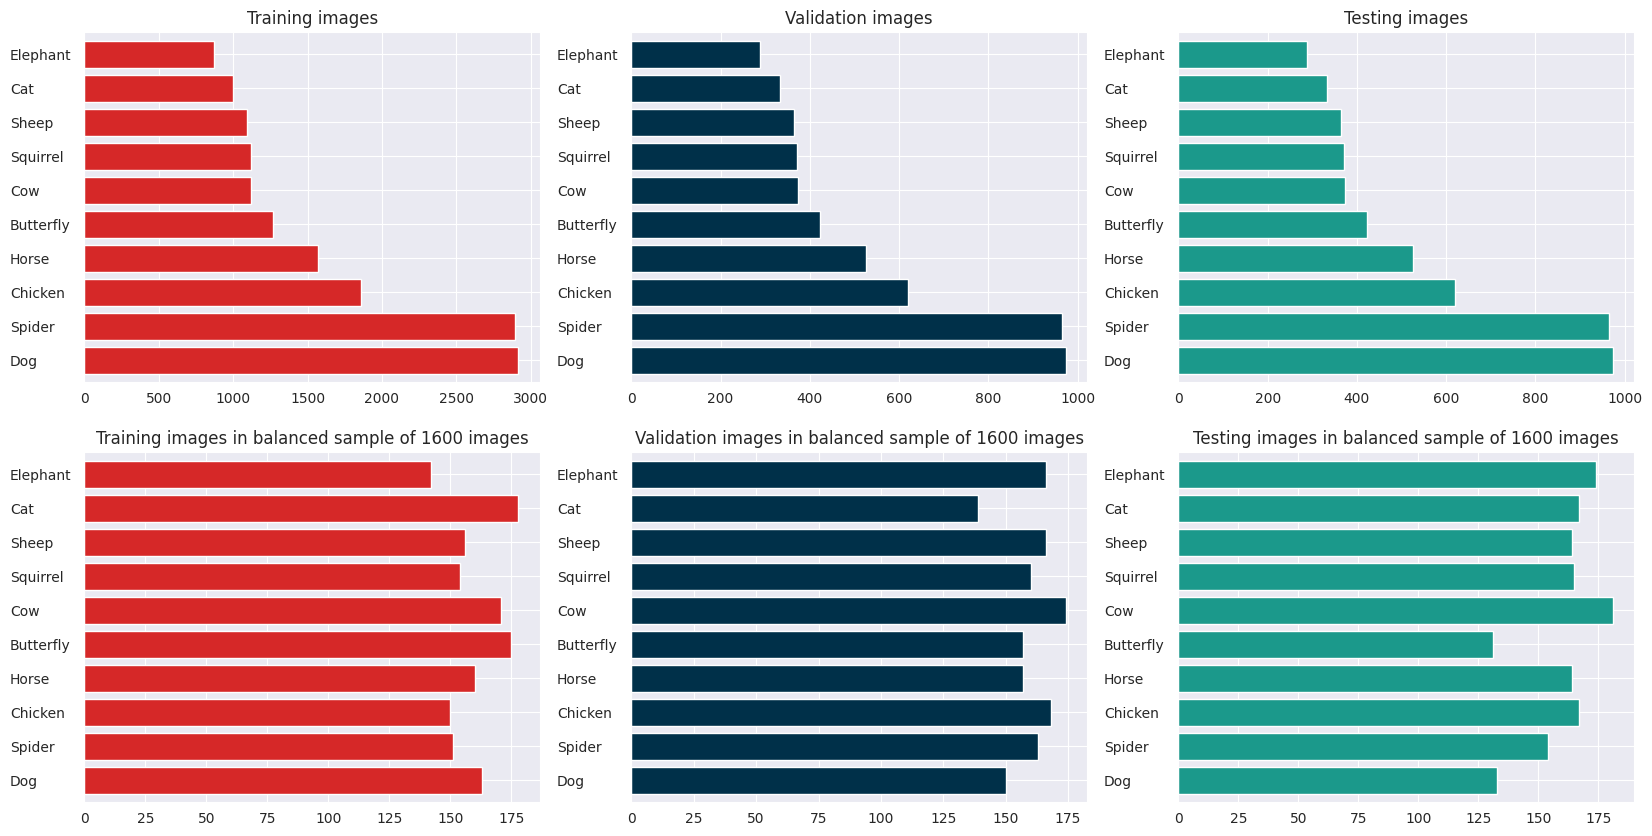

In [13]:
# Create fig and subplots
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20,10))

train_counts.plot(kind='barh', title='Training images', width=.8, color=my_palette[0], ax=ax[0,0])
val_counts.plot(kind='barh', title='Validation images', width=.8, color=my_palette[1], ax=ax[0,1])
test_counts.plot(kind='barh', title='Testing images', width=.8, color=my_palette[2], ax=ax[0,2])
train_balanced_counts.plot(kind='barh', title='Training images in balanced sample of 1600 images', width=.8, color=my_palette[0], ax=ax[1,0])
val_balanced_counts.plot(kind='barh', title='Validation images in balanced sample of 1600 images', width=.8, color=my_palette[1], ax=ax[1,1])
test_balanced_counts.plot(kind='barh', title='Testing images in balanced sample of 1600 images', width=.8, color=my_palette[2], ax=ax[1,2])

# Clean up y-axis labels
ax[0,0].set(ylabel=None)
ax[0,1].set(ylabel=None)
ax[0,2].set(ylabel=None)
ax[1,0].set(ylabel=None)
ax[1,1].set(ylabel=None)
ax[1,2].set(ylabel=None)

ax[0,0].tick_params(axis='y', pad=50)  
ax[0,1].tick_params(axis='y', pad=50)  
ax[0,2].tick_params(axis='y', pad=50)  
ax[1,0].tick_params(axis='y', pad=50)  
ax[1,1].tick_params(axis='y', pad=50)  
ax[1,2].tick_params(axis='y', pad=50)  

ax[0,0].set_yticklabels(ax[0,0].get_yticklabels(), ha='left')
ax[0,1].set_yticklabels(ax[0,1].get_yticklabels(), ha='left')
ax[0,2].set_yticklabels(ax[0,2].get_yticklabels(), ha='left')
ax[1,0].set_yticklabels(ax[1,0].get_yticklabels(), ha='left')
ax[1,1].set_yticklabels(ax[1,1].get_yticklabels(), ha='left')
ax[1,2].set_yticklabels(ax[1,2].get_yticklabels(), ha='left')

plt.savefig(os.path.join(FIGURE_PATH,'validate-balanced-classes.pdf'), bbox_inches='tight');

The plots of the imbalanced sets validate that the stratified sampling is splitting the train/val/test sets properly, and the plots of the balanced sets validate that the weighted random sampling function approximately balances each train/val/test set.

# Train model

### CNN

To classify images by animal, we will train a Convolutional Neural Network (CNN). 

A CNN uses filters that scan an image and extract specific features. Each convolutional layer in a CNN is built out of multiple convolutional filters (called kernels) each responsible for extracting one feature. Regions of an image that closely match a kernel's feature get amplified, and as the image passes through successive convolutional layers, the image is reduced to a collection of the model's filter features. This is inspired by human vision, which classifies objects by reducing them to a small collection of known features, e.g., a certain number and arrangement of eyes and legs allows us to distingish a dog from a spider. 

The output of each convolutional layer is passed through a pooling layer that down-samples (compresses) an image by dividing it into small windows and aggregating the contents of each window (we use max-pooling). Pooling reduces information while retaining the most important features, and a compressed image means there are fewer parameters for the model to learn and speeds up computation time.

After passing through all the convolutional and pooling layers, the image is flattened into a 1-d tensor and passed as input to a fully-connected neural network. The outpout of the entire CNN is 10 logits corresponding to each class in our dataset.

### Configurable model

Create a custom `CNN` class that subclasses `Module` from the `torch.nn` library. Inside the `CNN` class we define each convolution layer, pooling layer, and linear layer. To allow us to optimize the model's performance, we allow the kernel size and the sizes of the two linear layers in the fully-connected network to be configurable.

In [14]:
class CNN(nn.Module):
    '''Convolutional Neural Network for classifying images into 1 of 10 classes.'''
    def __init__(self, image_dim=300, kernel_size=5, lin1=120, lin2=84):
        '''Initialize the CNN and define the layers.'''
        super().__init__()

        # Kernel size will impact the input size of the fully-connected network
        conv1_dim = int(image_dim - kernel_size + 1)
        pool1_dim = int(conv1_dim / 2)
        conv2_dim = int(pool1_dim - kernel_size + 1)
        pool2_dim = int(conv2_dim / 2)

        self.conv1 = nn.Conv2d(3, 6, kernel_size) 
        self.conv2 = nn.Conv2d(6, 16, kernel_size)
        self.fc1 = nn.Linear(16 * pool2_dim * pool2_dim, lin1)
        self.fc2 = nn.Linear(lin1, lin2)
        self.fc3 = nn.Linear(lin2, 10)

    def forward(self, x):
        '''Forward propogation of image through model.'''
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, start_dim=1) # flatten tensor (start_dim=1 to keep batches)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Training and validation procedures

Define functions that pass images to a `torch` model in mini-batches with a `DataLoader` object and return the loss by passing the model output and target data through a loss function. If training the model, backpropagate the loss (compute the gradients) with the `backward()` method and update the model weights with an optimizer from the `torch.optim` library. Any metrics from the `torchmetrics` library passed to either function will be updated with each mini-batch.

In [15]:
def train_epoch(dataloader, model, loss_fn, optimizer, epoch=0, metrics=None, device='cpu'):
    '''Train model by iteratively passing mini-batches of data and updating the model weights, compute metrics, and return the loss.'''
    running_loss = 0.0
    steps = 0
    start = time.time()
    for minibatch, data in enumerate(dataloader):
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        logits = model(inputs)
        
        for metric in metrics:
            metric(logits, targets);

        loss = loss_fn(logits, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        steps += 1
        if minibatch % 500 == 499:
            print(f'epoch: {epoch + 1} | mini-batches: {minibatch + 1}/{len(dataloader)} | loss: {running_loss / steps:.3f} | time: {time.time() - start:.3f} s')
            running_loss = 0.0
            steps = 0
            start = time.time()
            
    return running_loss / steps

In [16]:
def validate_epoch(dataloader, model, loss_fn, epoch=0, metrics=None, device='cpu'):
    '''Validate the model by iterating over mini-batches, return the total loss.'''
    running_loss = 0.0
    steps = 0
    start = time.time()
    for minibatch, data in enumerate(dataloader):
        with torch.no_grad():
            inputs, targets = data
            inputs, targets = inputs.to(device), targets.to(device)
            logits = model(inputs)
            
            for metric in metrics:
                metric(logits, targets);

            loss = loss_fn(logits, targets)
            
            running_loss += loss.item()
            steps += 1
            if minibatch % 500 == 499:
                print(f'epoch: {epoch + 1} | mini-batches: {minibatch + 1}/{len(dataloader)} | loss: {running_loss / steps:.3f} | time: {time.time() - start:.3f} s')
                running_loss = 0.0
                steps = 0
                start = time.time()
            
    return running_loss / steps

### Training and validation loop

Since we are tuning the hyperparameters of our model, we will package the entire training and validation procedure in a function that can be repeatedly called with different hyperparameter configurations. It's a long function, so let's break it down:

1. First create separate `WeightedRandomSampler` objects for training and validation sets using our custom `balanced_sampler` function
    * Sample only from the testing or validation set by passing the corresponding indices
    * Here we can set the sample size--since we are over-sampling with data augmentation this can be larger than the "true" train/val set
1. Create `DataLoader` objects for reading image and label data from training and validation sets
    * Provide each loader with our dataset along with the respective sampler
    * Batch size is determined by the configuration dictionary
1. Initialize the `CNN` and place it onto the set `device` (CPU or GPU)
1. Initialize the training parameters
    * Our loss criterion is cross-entropy using the `CrossEntropyLoss` function from `torch.nn`, best for classification tasks
    * Weights are updated using stochastic gradient descent with the `optim.SGD` from `torch.optim`, note the learning rate is configurable
1. Initialize any metrics we want to use to evaluate the model's performance
    * Accuracy using `MulticlassAccuracy` from `torchmetrics.classification`
    * A confusion matrix using `MulticlassConfusionMatrix` from `torchmetrics.classification`
1. Check if there is a `ray.train` checkpoint to load a model from
1. Loop over each training epoch:
    * Call the training function and get the loss
    * Compute and reset the training metrics
    * Call the validation function and get the loss
    * Compute and reset the validation metrics
    * Create a `ray.train.Checkpoint`, save the the model state, and store the training/validation metrics as a `ray.train.report`

In [17]:
def train_and_validate_model(config, dataset, image_size=300, train_idx=None, val_idx=None, train_seed=0, val_seed=1, max_epochs=10, device='cpu'):
    '''Train and validate a cnn with configurable hyperparameters, save model at each epoch.'''
    
    start_epoch = 0
    print(f'Using device = {device}')
    
    # Balance the data with weighted samplers
    train_sampler = balanced_sampler(
        dataset.targets,
        subset_idx=train_idx,
        num_samples=len(train_idx),
        generator=Generator('cpu').manual_seed(train_seed)
    )
    val_sampler = balanced_sampler(
        dataset.targets,
        subset_idx=val_idx,
        num_samples=len(val_idx),
        generator=Generator('cpu').manual_seed(val_seed)
    )
    train_loader = DataLoader(
        dataset, 
        sampler=train_sampler, 
        batch_size=config['batch_size'], 
        num_workers=4
    )
    val_loader = DataLoader(
        dataset, 
        sampler=val_sampler, 
        batch_size=config['batch_size'], 
        num_workers=4
    )
    
    my_model = CNN(
        image_dim=image_size,
        kernel_size=config['kernel_size'],
        lin1=config['lin1'],
        lin2=config['lin2']
    )
    my_model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(my_model.parameters(), lr=config['learning_rate'], momentum=0.9)
    
    mca_metric = MulticlassAccuracy(num_classes=10).to(device)
    mccm_metric = MulticlassConfusionMatrix(num_classes=10).to(device)
    
    # Get the most recent checkpoint if trial was interrupted
    checkpoint = get_checkpoint()
    if checkpoint:
        with checkpoint.as_directory() as checkpoint_dir:
            checkpoint_state = torch.load(os.path.join(checkppoint_dir, 'checkpoint.pt'))
            start_epoch = checkpoint_state['epoch'] + 1
            my_model.load_state_dict(checkpoint_state['model_state'])
            optimizer.load_state_dict(checkpoint_state['optimizer_state'])
    
    for epoch in range(start_epoch, max_epochs):
        start = time.time()
        print('Training...')
        train_loss = train_epoch(train_loader, my_model, criterion, optimizer, epoch, [mca_metric, mccm_metric], device)
        train_accuracy = mca_metric.compute()
        train_confusion_matrix = mccm_metric.compute()
        print(f'Training summary | epochs: {epoch + 1} | loss: {train_loss:.3f} | accuracy: {train_accuracy.cpu().item():.3f} | time: {time.time() - start:.3f} s')
        mca_metric.reset() # reset metrics before validation
        mccm_metric.reset()

        start = time.time()
        print('Validating...')
        val_loss = validate_epoch(val_loader, my_model, criterion, epoch, [mca_metric, mccm_metric], device)
        val_accuracy = mca_metric.compute()
        val_confusion_matrix = mccm_metric.compute()
        print(f'Validation summary | epochs: {epoch + 1} | loss: {val_loss:.3f} | accuracy: {val_accuracy.cpu().item():.3f} | time: {time.time() - start:.3f} s')
        mca_metric.reset() # reset metrics before next epoch
        mccm_metric.reset()

        # Training and validation metrics get loaded into the ray.train.report
        metric_data = {
            'train_loss': train_loss,
            'train_accuracy': train_accuracy.cpu().item(),
            'train_confusion_matrix': train_confusion_matrix.cpu().numpy(),
            'val_loss': val_loss,
            'val_accuracy': val_accuracy.cpu().item(),
            'val_confusion_matrix': val_confusion_matrix.cpu().numpy()
        }
        
        checkpoint_data = {
            'epoch': epoch,
            'model_state': my_model.state_dict(),
            'optimizer_state': optimizer.state_dict()
        }
        
        # Save the model state and metric data at each epoch so it can be loaded later for analysis and testing
        with tempfile.TemporaryDirectory() as tmpdir:
            torch.save(checkpoint_data, os.path.join(tmpdir, 'checkpoint.pt'))
            train.report(metric_data, checkpoint=Checkpoint.from_directory(tmpdir))
            
    print('Done training model!')

### Hyperparameter tuning

To get the best model performance, we will tune the hyperparameters using tools availible from Ray. Ray's `tune` library will let us a separate trail for each configuration and select the best model from all the trials.

We define our search space using a Python dictionary containing each hyperparameter we want to tune and the values to consider. Configurations can be sampled randomly or in a grid search. In this analysis we tune:

* Kernel size of the convolutional layers in our CNN
* The sizes of both fully-connected layers in out CNN
* The learning rate (step-size) when performing stochastic gradient descent
* The mini-batch size of data to load into the model before updating the weights

A `ASHAScheduler` from the `ray.tune.schedulers` library will allow us to early-terminate any trial that is under-performing previous trials by whatever metric we supply. This greatly speeds up the hyperparameter tuning.

The training and validation function, search space, tune configurations, and run configurations are all passed to a `ray.tune.Tuner` object. By calling the `fit()` method on the `Tuner` we run through all the trails, saving each model at each checkpoint (epoch) along the way.

In [18]:
MAX_EPOCHS = 20
TUNE_SAMPLES = 40

# Configure hyperparameter search space here
search_space = {
    'kernel_size': tune.choice([3, 5]),
    'lin1': tune.choice([2 ** i for i in range(3, 9)]),
    'lin2': tune.choice([2 ** i for i in range(3, 9)]),
    'learning_rate': tune.loguniform(0.001, 0.1),
    'batch_size': tune.choice([16, 32, 64, 128, 256])
}

# Scheduler for terminating trials early
my_scheduler = ASHAScheduler(
    metric='val_loss',
    mode='min',
    max_t=MAX_EPOCHS,
    grace_period=1,
    reduction_factor=2
)

train_fn = partial(
    train_and_validate_model,
    dataset=dataset, 
    image_size=IMAGE_SIZE,
    train_idx=train_idx, 
    val_idx=val_idx, 
    train_seed=SEED_1, 
    val_seed=SEED_2,
    max_epochs=MAX_EPOCHS,
    device=device
)

# Assign computing resources to training loop here
trainer_with_gpu = tune.with_resources(train_fn, {'cpu': 4, 'gpu': 1 if torch.cuda.is_available() else 0})

tuner = Tuner(
    trainer_with_gpu,
    param_space=search_space,
    tune_config=TuneConfig(num_samples=TUNE_SAMPLES, scheduler=my_scheduler), # number of parameter configurations if randomly sampling search space (1 if grid search)
    run_config=RunConfig(name='models', storage_path=OUT_PATH) # Specify where to save model checkpoints
)

Tune the hyperparameters! This takes a considerable amount of time, but we can monitor each trial's progress with the Trial Status table and print-outs.

In [19]:
results = tuner.fit()

(func pid=482) Using device = cuda
(func pid=482) Training...
(func pid=482) Training summary | epochs: 1 | loss: 2.314 | accuracy: 0.100 | time: 72.569 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 1 | loss: 2.310 | accuracy: 0.102 | time: 23.758 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00000_0_batch_size=256,kernel_size=3,learning_rate=0.0013,lin1=64,lin2=8_2024-07-02_22-49-35/checkpoint_000000)


(func pid=482) Training summary | epochs: 2 | loss: 2.309 | accuracy: 0.101 | time: 70.082 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 2 | loss: 2.304 | accuracy: 0.100 | time: 22.662 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00000_0_batch_size=256,kernel_size=3,learning_rate=0.0013,lin1=64,lin2=8_2024-07-02_22-49-35/checkpoint_000001)


(func pid=482) Training summary | epochs: 3 | loss: 2.303 | accuracy: 0.102 | time: 68.724 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 3 | loss: 2.303 | accuracy: 0.100 | time: 22.646 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00000_0_batch_size=256,kernel_size=3,learning_rate=0.0013,lin1=64,lin2=8_2024-07-02_22-49-35/checkpoint_000002)


(func pid=482) Training summary | epochs: 4 | loss: 2.302 | accuracy: 0.103 | time: 67.144 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 4 | loss: 2.302 | accuracy: 0.110 | time: 22.194 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00000_0_batch_size=256,kernel_size=3,learning_rate=0.0013,lin1=64,lin2=8_2024-07-02_22-49-35/checkpoint_000003)


(func pid=482) Training summary | epochs: 5 | loss: 2.302 | accuracy: 0.111 | time: 67.135 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 5 | loss: 2.301 | accuracy: 0.107 | time: 22.003 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00000_0_batch_size=256,kernel_size=3,learning_rate=0.0013,lin1=64,lin2=8_2024-07-02_22-49-35/checkpoint_000004)


(func pid=482) Training summary | epochs: 6 | loss: 2.300 | accuracy: 0.110 | time: 69.444 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 6 | loss: 2.299 | accuracy: 0.114 | time: 22.862 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00000_0_batch_size=256,kernel_size=3,learning_rate=0.0013,lin1=64,lin2=8_2024-07-02_22-49-35/checkpoint_000005)


(func pid=482) Training summary | epochs: 7 | loss: 2.299 | accuracy: 0.114 | time: 66.539 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 7 | loss: 2.298 | accuracy: 0.108 | time: 21.759 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00000_0_batch_size=256,kernel_size=3,learning_rate=0.0013,lin1=64,lin2=8_2024-07-02_22-49-35/checkpoint_000006)


(func pid=482) Training summary | epochs: 8 | loss: 2.297 | accuracy: 0.129 | time: 68.630 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 8 | loss: 2.297 | accuracy: 0.134 | time: 22.763 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00000_0_batch_size=256,kernel_size=3,learning_rate=0.0013,lin1=64,lin2=8_2024-07-02_22-49-35/checkpoint_000007)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 9 | loss: 2.296 | accuracy: 0.128 | time: 66.852 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 9 | loss: 2.295 | accuracy: 0.124 | time: 22.165 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00000_0_batch_size=256,kernel_size=3,learning_rate=0.0013,lin1=64,lin2=8_2024-07-02_22-49-35/checkpoint_000008)


(func pid=482) Training summary | epochs: 10 | loss: 2.292 | accuracy: 0.134 | time: 66.290 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 10 | loss: 2.290 | accuracy: 0.138 | time: 21.937 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00000_0_batch_size=256,kernel_size=3,learning_rate=0.0013,lin1=64,lin2=8_2024-07-02_22-49-35/checkpoint_000009)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 11 | loss: 2.288 | accuracy: 0.137 | time: 68.603 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 11 | loss: 2.287 | accuracy: 0.128 | time: 22.473 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00000_0_batch_size=256,kernel_size=3,learning_rate=0.0013,lin1=64,lin2=8_2024-07-02_22-49-35/checkpoint_000010)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 12 | loss: 2.283 | accuracy: 0.135 | time: 67.859 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 12 | loss: 2.282 | accuracy: 0.140 | time: 22.559 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00000_0_batch_size=256,kernel_size=3,learning_rate=0.0013,lin1=64,lin2=8_2024-07-02_22-49-35/checkpoint_000011)


(func pid=482) Training summary | epochs: 13 | loss: 2.276 | accuracy: 0.145 | time: 68.695 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 13 | loss: 2.279 | accuracy: 0.140 | time: 22.674 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00000_0_batch_size=256,kernel_size=3,learning_rate=0.0013,lin1=64,lin2=8_2024-07-02_22-49-35/checkpoint_000012)


(func pid=482) Training summary | epochs: 14 | loss: 2.271 | accuracy: 0.152 | time: 68.438 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 14 | loss: 2.277 | accuracy: 0.146 | time: 22.737 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00000_0_batch_size=256,kernel_size=3,learning_rate=0.0013,lin1=64,lin2=8_2024-07-02_22-49-35/checkpoint_000013)


(func pid=482) Training summary | epochs: 15 | loss: 2.266 | accuracy: 0.157 | time: 67.922 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 15 | loss: 2.269 | accuracy: 0.149 | time: 22.394 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00000_0_batch_size=256,kernel_size=3,learning_rate=0.0013,lin1=64,lin2=8_2024-07-02_22-49-35/checkpoint_000014)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 16 | loss: 2.263 | accuracy: 0.160 | time: 70.006 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 16 | loss: 2.272 | accuracy: 0.146 | time: 22.371 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00000_0_batch_size=256,kernel_size=3,learning_rate=0.0013,lin1=64,lin2=8_2024-07-02_22-49-35/checkpoint_000015)


(func pid=482) Training summary | epochs: 17 | loss: 2.256 | accuracy: 0.159 | time: 67.163 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 17 | loss: 2.253 | accuracy: 0.161 | time: 21.966 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00000_0_batch_size=256,kernel_size=3,learning_rate=0.0013,lin1=64,lin2=8_2024-07-02_22-49-35/checkpoint_000016)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 18 | loss: 2.251 | accuracy: 0.158 | time: 66.613 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 18 | loss: 2.256 | accuracy: 0.146 | time: 22.220 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00000_0_batch_size=256,kernel_size=3,learning_rate=0.0013,lin1=64,lin2=8_2024-07-02_22-49-35/checkpoint_000017)


(func pid=482) Training summary | epochs: 19 | loss: 2.246 | accuracy: 0.160 | time: 68.161 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 19 | loss: 2.252 | accuracy: 0.152 | time: 22.316 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00000_0_batch_size=256,kernel_size=3,learning_rate=0.0013,lin1=64,lin2=8_2024-07-02_22-49-35/checkpoint_000018)


(func pid=482) Training summary | epochs: 20 | loss: 2.245 | accuracy: 0.165 | time: 66.517 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 20 | loss: 2.250 | accuracy: 0.157 | time: 22.008 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00000_0_batch_size=256,kernel_size=3,learning_rate=0.0013,lin1=64,lin2=8_2024-07-02_22-49-35/checkpoint_000019)


(func pid=482) Using device = cuda
(func pid=482) Training...
(func pid=482) Training summary | epochs: 1 | loss: 2.304 | accuracy: 0.102 | time: 67.517 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 1 | loss: 2.301 | accuracy: 0.103 | time: 22.608 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00001_1_batch_size=256,kernel_size=3,learning_rate=0.0489,lin1=8,lin2=256_2024-07-02_22-49-36/checkpoint_000000)


(func pid=482) Training summary | epochs: 2 | loss: 2.285 | accuracy: 0.124 | time: 67.640 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 2 | loss: 2.269 | accuracy: 0.140 | time: 22.692 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00001_1_batch_size=256,kernel_size=3,learning_rate=0.0489,lin1=8,lin2=256_2024-07-02_22-49-36/checkpoint_000001)


(func pid=482) Training summary | epochs: 3 | loss: 2.243 | accuracy: 0.153 | time: 67.838 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00001_1_batch_size=256,kernel_size=3,learning_rate=0.0489,lin1=8,lin2=256_2024-07-02_22-49-36/checkpoint_000002)


(func pid=482) Validation summary | epochs: 3 | loss: 2.275 | accuracy: 0.144 | time: 22.159 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 4 | loss: 2.219 | accuracy: 0.168 | time: 68.006 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00001_1_batch_size=256,kernel_size=3,learning_rate=0.0489,lin1=8,lin2=256_2024-07-02_22-49-36/checkpoint_000003)


(func pid=482) Validation summary | epochs: 4 | loss: 2.223 | accuracy: 0.164 | time: 22.490 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 5 | loss: 2.210 | accuracy: 0.176 | time: 66.778 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00001_1_batch_size=256,kernel_size=3,learning_rate=0.0489,lin1=8,lin2=256_2024-07-02_22-49-36/checkpoint_000004)


(func pid=482) Validation summary | epochs: 5 | loss: 2.246 | accuracy: 0.154 | time: 21.696 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 6 | loss: 2.186 | accuracy: 0.197 | time: 68.215 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00001_1_batch_size=256,kernel_size=3,learning_rate=0.0489,lin1=8,lin2=256_2024-07-02_22-49-36/checkpoint_000005)


(func pid=482) Validation summary | epochs: 6 | loss: 2.253 | accuracy: 0.178 | time: 22.447 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 7 | loss: 2.163 | accuracy: 0.206 | time: 68.215 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 7 | loss: 2.160 | accuracy: 0.203 | time: 22.312 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00001_1_batch_size=256,kernel_size=3,learning_rate=0.0489,lin1=8,lin2=256_2024-07-02_22-49-36/checkpoint_000006)


(func pid=482) Training summary | epochs: 8 | loss: 2.149 | accuracy: 0.208 | time: 67.932 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00001_1_batch_size=256,kernel_size=3,learning_rate=0.0489,lin1=8,lin2=256_2024-07-02_22-49-36/checkpoint_000007)


(func pid=482) Validation summary | epochs: 8 | loss: 2.141 | accuracy: 0.210 | time: 22.142 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 9 | loss: 2.116 | accuracy: 0.222 | time: 67.889 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00001_1_batch_size=256,kernel_size=3,learning_rate=0.0489,lin1=8,lin2=256_2024-07-02_22-49-36/checkpoint_000008)


(func pid=482) Validation summary | epochs: 9 | loss: 2.126 | accuracy: 0.216 | time: 22.465 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 10 | loss: 2.111 | accuracy: 0.224 | time: 66.339 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 10 | loss: 2.142 | accuracy: 0.205 | time: 21.826 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00001_1_batch_size=256,kernel_size=3,learning_rate=0.0489,lin1=8,lin2=256_2024-07-02_22-49-36/checkpoint_000009)


(func pid=482) Training summary | epochs: 11 | loss: 2.123 | accuracy: 0.222 | time: 67.693 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00001_1_batch_size=256,kernel_size=3,learning_rate=0.0489,lin1=8,lin2=256_2024-07-02_22-49-36/checkpoint_000010)


(func pid=482) Validation summary | epochs: 11 | loss: 2.143 | accuracy: 0.196 | time: 22.139 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 12 | loss: 2.084 | accuracy: 0.228 | time: 66.366 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00001_1_batch_size=256,kernel_size=3,learning_rate=0.0489,lin1=8,lin2=256_2024-07-02_22-49-36/checkpoint_000011)


(func pid=482) Validation summary | epochs: 12 | loss: 2.152 | accuracy: 0.212 | time: 22.197 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 13 | loss: 2.108 | accuracy: 0.230 | time: 67.024 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00001_1_batch_size=256,kernel_size=3,learning_rate=0.0489,lin1=8,lin2=256_2024-07-02_22-49-36/checkpoint_000012)


(func pid=482) Validation summary | epochs: 13 | loss: 2.115 | accuracy: 0.215 | time: 22.027 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 14 | loss: 2.076 | accuracy: 0.237 | time: 65.058 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00001_1_batch_size=256,kernel_size=3,learning_rate=0.0489,lin1=8,lin2=256_2024-07-02_22-49-36/checkpoint_000013)


(func pid=482) Validation summary | epochs: 14 | loss: 2.104 | accuracy: 0.222 | time: 21.944 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 15 | loss: 2.051 | accuracy: 0.250 | time: 66.629 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00001_1_batch_size=256,kernel_size=3,learning_rate=0.0489,lin1=8,lin2=256_2024-07-02_22-49-36/checkpoint_000014)


(func pid=482) Validation summary | epochs: 15 | loss: 2.090 | accuracy: 0.229 | time: 22.063 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 16 | loss: 2.035 | accuracy: 0.257 | time: 67.281 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00001_1_batch_size=256,kernel_size=3,learning_rate=0.0489,lin1=8,lin2=256_2024-07-02_22-49-36/checkpoint_000015)


(func pid=482) Validation summary | epochs: 16 | loss: 2.045 | accuracy: 0.259 | time: 22.414 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 17 | loss: 2.045 | accuracy: 0.255 | time: 66.452 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00001_1_batch_size=256,kernel_size=3,learning_rate=0.0489,lin1=8,lin2=256_2024-07-02_22-49-36/checkpoint_000016)


(func pid=482) Validation summary | epochs: 17 | loss: 2.085 | accuracy: 0.226 | time: 22.067 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 18 | loss: 2.039 | accuracy: 0.252 | time: 66.627 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00001_1_batch_size=256,kernel_size=3,learning_rate=0.0489,lin1=8,lin2=256_2024-07-02_22-49-36/checkpoint_000017)


(func pid=482) Validation summary | epochs: 18 | loss: 2.053 | accuracy: 0.243 | time: 21.730 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 19 | loss: 1.991 | accuracy: 0.271 | time: 67.707 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00001_1_batch_size=256,kernel_size=3,learning_rate=0.0489,lin1=8,lin2=256_2024-07-02_22-49-36/checkpoint_000018)


(func pid=482) Validation summary | epochs: 19 | loss: 2.045 | accuracy: 0.254 | time: 21.923 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 20 | loss: 1.994 | accuracy: 0.274 | time: 68.340 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00001_1_batch_size=256,kernel_size=3,learning_rate=0.0489,lin1=8,lin2=256_2024-07-02_22-49-36/checkpoint_000019)


(func pid=482) Validation summary | epochs: 20 | loss: 2.056 | accuracy: 0.237 | time: 22.147 s
(func pid=482) Using device = cuda
(func pid=482) Training...
(func pid=482) Training summary | epochs: 1 | loss: 2.304 | accuracy: 0.100 | time: 70.620 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 1 | loss: 2.301 | accuracy: 0.109 | time: 23.376 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00002_2_batch_size=32,kernel_size=3,learning_rate=0.0175,lin1=256,lin2=16_2024-07-02_22-49-36/checkpoint_000000)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 2 | loss: 2.303 | accuracy: 0.102 | time: 67.314 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 2 | loss: 2.302 | accuracy: 0.100 | time: 21.750 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00002_2_batch_size=32,kernel_size=3,learning_rate=0.0175,lin1=256,lin2=16_2024-07-02_22-49-36/checkpoint_000001)


(func pid=482) Using device = cuda
(func pid=482) Training...
(func pid=482) Training summary | epochs: 1 | loss: 2.299 | accuracy: 0.109 | time: 66.116 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00003_3_batch_size=256,kernel_size=5,learning_rate=0.0222,lin1=8,lin2=16_2024-07-02_22-49-36/checkpoint_000000)


(func pid=482) Validation summary | epochs: 1 | loss: 2.296 | accuracy: 0.104 | time: 21.476 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 2 | loss: 2.287 | accuracy: 0.121 | time: 66.778 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00003_3_batch_size=256,kernel_size=5,learning_rate=0.0222,lin1=8,lin2=16_2024-07-02_22-49-36/checkpoint_000001)


(func pid=482) Validation summary | epochs: 2 | loss: 2.285 | accuracy: 0.133 | time: 22.568 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 3 | loss: 2.266 | accuracy: 0.141 | time: 67.459 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00003_3_batch_size=256,kernel_size=5,learning_rate=0.0222,lin1=8,lin2=16_2024-07-02_22-49-36/checkpoint_000002)


(func pid=482) Validation summary | epochs: 3 | loss: 2.250 | accuracy: 0.158 | time: 21.840 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 4 | loss: 2.239 | accuracy: 0.156 | time: 67.818 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00003_3_batch_size=256,kernel_size=5,learning_rate=0.0222,lin1=8,lin2=16_2024-07-02_22-49-36/checkpoint_000003)


(func pid=482) Validation summary | epochs: 4 | loss: 2.246 | accuracy: 0.157 | time: 22.710 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 5 | loss: 2.254 | accuracy: 0.146 | time: 66.900 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00003_3_batch_size=256,kernel_size=5,learning_rate=0.0222,lin1=8,lin2=16_2024-07-02_22-49-36/checkpoint_000004)


(func pid=482) Validation summary | epochs: 5 | loss: 2.227 | accuracy: 0.165 | time: 22.039 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 6 | loss: 2.214 | accuracy: 0.173 | time: 68.783 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00003_3_batch_size=256,kernel_size=5,learning_rate=0.0222,lin1=8,lin2=16_2024-07-02_22-49-36/checkpoint_000005)


(func pid=482) Validation summary | epochs: 6 | loss: 2.194 | accuracy: 0.194 | time: 21.921 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 7 | loss: 2.197 | accuracy: 0.179 | time: 67.758 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00003_3_batch_size=256,kernel_size=5,learning_rate=0.0222,lin1=8,lin2=16_2024-07-02_22-49-36/checkpoint_000006)


(func pid=482) Validation summary | epochs: 7 | loss: 2.179 | accuracy: 0.187 | time: 22.105 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 8 | loss: 2.171 | accuracy: 0.199 | time: 67.081 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00003_3_batch_size=256,kernel_size=5,learning_rate=0.0222,lin1=8,lin2=16_2024-07-02_22-49-36/checkpoint_000007)


(func pid=482) Validation summary | epochs: 8 | loss: 2.178 | accuracy: 0.201 | time: 22.733 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 9 | loss: 2.147 | accuracy: 0.212 | time: 67.237 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00003_3_batch_size=256,kernel_size=5,learning_rate=0.0222,lin1=8,lin2=16_2024-07-02_22-49-36/checkpoint_000008)


(func pid=482) Validation summary | epochs: 9 | loss: 2.133 | accuracy: 0.213 | time: 22.715 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 10 | loss: 2.133 | accuracy: 0.217 | time: 67.431 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00003_3_batch_size=256,kernel_size=5,learning_rate=0.0222,lin1=8,lin2=16_2024-07-02_22-49-36/checkpoint_000009)


(func pid=482) Validation summary | epochs: 10 | loss: 2.136 | accuracy: 0.212 | time: 22.113 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 11 | loss: 2.125 | accuracy: 0.220 | time: 68.835 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00003_3_batch_size=256,kernel_size=5,learning_rate=0.0222,lin1=8,lin2=16_2024-07-02_22-49-36/checkpoint_000010)


(func pid=482) Validation summary | epochs: 11 | loss: 2.107 | accuracy: 0.227 | time: 22.229 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 12 | loss: 2.068 | accuracy: 0.242 | time: 68.260 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00003_3_batch_size=256,kernel_size=5,learning_rate=0.0222,lin1=8,lin2=16_2024-07-02_22-49-36/checkpoint_000011)


(func pid=482) Validation summary | epochs: 12 | loss: 2.087 | accuracy: 0.229 | time: 22.685 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 13 | loss: 2.072 | accuracy: 0.241 | time: 67.891 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00003_3_batch_size=256,kernel_size=5,learning_rate=0.0222,lin1=8,lin2=16_2024-07-02_22-49-36/checkpoint_000012)


(func pid=482) Validation summary | epochs: 13 | loss: 2.052 | accuracy: 0.245 | time: 22.049 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 14 | loss: 2.047 | accuracy: 0.249 | time: 65.213 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00003_3_batch_size=256,kernel_size=5,learning_rate=0.0222,lin1=8,lin2=16_2024-07-02_22-49-36/checkpoint_000013)


(func pid=482) Validation summary | epochs: 14 | loss: 2.063 | accuracy: 0.243 | time: 22.213 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 15 | loss: 2.016 | accuracy: 0.260 | time: 65.994 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00003_3_batch_size=256,kernel_size=5,learning_rate=0.0222,lin1=8,lin2=16_2024-07-02_22-49-36/checkpoint_000014)


(func pid=482) Validation summary | epochs: 15 | loss: 2.017 | accuracy: 0.260 | time: 21.952 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 16 | loss: 1.976 | accuracy: 0.281 | time: 67.692 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00003_3_batch_size=256,kernel_size=5,learning_rate=0.0222,lin1=8,lin2=16_2024-07-02_22-49-36/checkpoint_000015)


(func pid=482) Validation summary | epochs: 16 | loss: 2.003 | accuracy: 0.260 | time: 22.378 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 17 | loss: 1.949 | accuracy: 0.285 | time: 68.071 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00003_3_batch_size=256,kernel_size=5,learning_rate=0.0222,lin1=8,lin2=16_2024-07-02_22-49-36/checkpoint_000016)


(func pid=482) Validation summary | epochs: 17 | loss: 1.953 | accuracy: 0.278 | time: 22.482 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 18 | loss: 1.897 | accuracy: 0.304 | time: 67.075 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 18 | loss: 1.936 | accuracy: 0.296 | time: 22.433 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00003_3_batch_size=256,kernel_size=5,learning_rate=0.0222,lin1=8,lin2=16_2024-07-02_22-49-36/checkpoint_000017)


(func pid=482) Training summary | epochs: 19 | loss: 1.884 | accuracy: 0.309 | time: 68.217 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 19 | loss: 1.895 | accuracy: 0.318 | time: 21.916 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00003_3_batch_size=256,kernel_size=5,learning_rate=0.0222,lin1=8,lin2=16_2024-07-02_22-49-36/checkpoint_000018)


(func pid=482) Training summary | epochs: 20 | loss: 1.856 | accuracy: 0.325 | time: 67.250 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 20 | loss: 1.941 | accuracy: 0.280 | time: 21.863 s
(func pid=482) Using device = cuda


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00003_3_batch_size=256,kernel_size=5,learning_rate=0.0222,lin1=8,lin2=16_2024-07-02_22-49-36/checkpoint_000019)


(func pid=482) Training...
(func pid=482) epoch: 1 | mini-batches: 500/982 | loss: 2.300 | time: 35.598 s
(func pid=482) Training summary | epochs: 1 | loss: 2.270 | accuracy: 0.126 | time: 69.950 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 1 | loss: 2.262 | accuracy: 0.155 | time: 22.601 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00004_4_batch_size=16,kernel_size=3,learning_rate=0.0144,lin1=128,lin2=256_2024-07-02_22-49-36/checkpoint_000000)


(func pid=482) Training...
(func pid=482) epoch: 2 | mini-batches: 500/982 | loss: 2.242 | time: 36.965 s
(func pid=482) Training summary | epochs: 2 | loss: 2.204 | accuracy: 0.169 | time: 69.862 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 2 | loss: 2.166 | accuracy: 0.205 | time: 22.772 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00004_4_batch_size=16,kernel_size=3,learning_rate=0.0144,lin1=128,lin2=256_2024-07-02_22-49-36/checkpoint_000001)


(func pid=482) Training...
(func pid=482) epoch: 3 | mini-batches: 500/982 | loss: 2.147 | time: 37.077 s
(func pid=482) Training summary | epochs: 3 | loss: 2.117 | accuracy: 0.216 | time: 70.881 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 3 | loss: 2.116 | accuracy: 0.230 | time: 23.539 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00004_4_batch_size=16,kernel_size=3,learning_rate=0.0144,lin1=128,lin2=256_2024-07-02_22-49-36/checkpoint_000002)


(func pid=482) Training...
(func pid=482) epoch: 4 | mini-batches: 500/982 | loss: 2.089 | time: 37.008 s
(func pid=482) Training summary | epochs: 4 | loss: 2.044 | accuracy: 0.247 | time: 70.679 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 4 | loss: 2.053 | accuracy: 0.255 | time: 23.129 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00004_4_batch_size=16,kernel_size=3,learning_rate=0.0144,lin1=128,lin2=256_2024-07-02_22-49-36/checkpoint_000003)


(func pid=482) Training...
(func pid=482) epoch: 5 | mini-batches: 500/982 | loss: 2.043 | time: 37.494 s
(func pid=482) Training summary | epochs: 5 | loss: 1.994 | accuracy: 0.267 | time: 72.697 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 5 | loss: 2.197 | accuracy: 0.216 | time: 22.588 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00004_4_batch_size=16,kernel_size=3,learning_rate=0.0144,lin1=128,lin2=256_2024-07-02_22-49-36/checkpoint_000004)


(func pid=482) Training...
(func pid=482) epoch: 6 | mini-batches: 500/982 | loss: 1.977 | time: 36.564 s
(func pid=482) Training summary | epochs: 6 | loss: 1.977 | accuracy: 0.294 | time: 71.623 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 6 | loss: 2.004 | accuracy: 0.278 | time: 23.198 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00004_4_batch_size=16,kernel_size=3,learning_rate=0.0144,lin1=128,lin2=256_2024-07-02_22-49-36/checkpoint_000005)


(func pid=482) Training...
(func pid=482) epoch: 7 | mini-batches: 500/982 | loss: 1.963 | time: 36.516 s
(func pid=482) Training summary | epochs: 7 | loss: 1.927 | accuracy: 0.307 | time: 72.796 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 7 | loss: 1.999 | accuracy: 0.281 | time: 22.778 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00004_4_batch_size=16,kernel_size=3,learning_rate=0.0144,lin1=128,lin2=256_2024-07-02_22-49-36/checkpoint_000006)


(func pid=482) Training...
(func pid=482) epoch: 8 | mini-batches: 500/982 | loss: 1.934 | time: 36.148 s
(func pid=482) Training summary | epochs: 8 | loss: 1.918 | accuracy: 0.321 | time: 71.573 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 8 | loss: 1.983 | accuracy: 0.295 | time: 22.596 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00004_4_batch_size=16,kernel_size=3,learning_rate=0.0144,lin1=128,lin2=256_2024-07-02_22-49-36/checkpoint_000007)


(func pid=482) Training...
(func pid=482) epoch: 9 | mini-batches: 500/982 | loss: 1.927 | time: 36.187 s
(func pid=482) Training summary | epochs: 9 | loss: 1.900 | accuracy: 0.322 | time: 70.375 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 9 | loss: 1.986 | accuracy: 0.288 | time: 22.782 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00004_4_batch_size=16,kernel_size=3,learning_rate=0.0144,lin1=128,lin2=256_2024-07-02_22-49-36/checkpoint_000008)


(func pid=482) Training...
(func pid=482) epoch: 10 | mini-batches: 500/982 | loss: 1.903 | time: 36.520 s
(func pid=482) Training summary | epochs: 10 | loss: 1.903 | accuracy: 0.331 | time: 70.419 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 10 | loss: 1.935 | accuracy: 0.312 | time: 22.233 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00004_4_batch_size=16,kernel_size=3,learning_rate=0.0144,lin1=128,lin2=256_2024-07-02_22-49-36/checkpoint_000009)


(func pid=482) Training...
(func pid=482) epoch: 11 | mini-batches: 500/982 | loss: 1.879 | time: 36.316 s
(func pid=482) Training summary | epochs: 11 | loss: 1.888 | accuracy: 0.338 | time: 70.335 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 11 | loss: 1.983 | accuracy: 0.304 | time: 22.709 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00004_4_batch_size=16,kernel_size=3,learning_rate=0.0144,lin1=128,lin2=256_2024-07-02_22-49-36/checkpoint_000010)


(func pid=482) Training...
(func pid=482) epoch: 12 | mini-batches: 500/982 | loss: 1.855 | time: 36.346 s
(func pid=482) Training summary | epochs: 12 | loss: 1.886 | accuracy: 0.341 | time: 69.850 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 12 | loss: 1.999 | accuracy: 0.298 | time: 22.706 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00004_4_batch_size=16,kernel_size=3,learning_rate=0.0144,lin1=128,lin2=256_2024-07-02_22-49-36/checkpoint_000011)


(func pid=482) Training...
(func pid=482) epoch: 13 | mini-batches: 500/982 | loss: 1.857 | time: 36.477 s
(func pid=482) Training summary | epochs: 13 | loss: 1.895 | accuracy: 0.344 | time: 70.257 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 13 | loss: 2.006 | accuracy: 0.286 | time: 22.484 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00004_4_batch_size=16,kernel_size=3,learning_rate=0.0144,lin1=128,lin2=256_2024-07-02_22-49-36/checkpoint_000012)


(func pid=482) Training...
(func pid=482) epoch: 14 | mini-batches: 500/982 | loss: 1.878 | time: 34.931 s
(func pid=482) Training summary | epochs: 14 | loss: 1.864 | accuracy: 0.349 | time: 67.573 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 14 | loss: 1.994 | accuracy: 0.301 | time: 22.515 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00004_4_batch_size=16,kernel_size=3,learning_rate=0.0144,lin1=128,lin2=256_2024-07-02_22-49-36/checkpoint_000013)


(func pid=482) Training...
(func pid=482) epoch: 15 | mini-batches: 500/982 | loss: 1.806 | time: 36.159 s
(func pid=482) Training summary | epochs: 15 | loss: 1.857 | accuracy: 0.364 | time: 69.284 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 15 | loss: 2.066 | accuracy: 0.266 | time: 22.272 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00004_4_batch_size=16,kernel_size=3,learning_rate=0.0144,lin1=128,lin2=256_2024-07-02_22-49-36/checkpoint_000014)


(func pid=482) Training...
(func pid=482) epoch: 16 | mini-batches: 500/982 | loss: 1.849 | time: 36.413 s
(func pid=482) Training summary | epochs: 16 | loss: 1.822 | accuracy: 0.360 | time: 71.366 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 16 | loss: 1.960 | accuracy: 0.314 | time: 22.933 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00004_4_batch_size=16,kernel_size=3,learning_rate=0.0144,lin1=128,lin2=256_2024-07-02_22-49-36/checkpoint_000015)


(func pid=482) Training...
(func pid=482) epoch: 17 | mini-batches: 500/982 | loss: 1.838 | time: 35.295 s
(func pid=482) Training summary | epochs: 17 | loss: 1.819 | accuracy: 0.362 | time: 68.599 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 17 | loss: 1.980 | accuracy: 0.310 | time: 22.203 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00004_4_batch_size=16,kernel_size=3,learning_rate=0.0144,lin1=128,lin2=256_2024-07-02_22-49-36/checkpoint_000016)


(func pid=482) Training...
(func pid=482) epoch: 18 | mini-batches: 500/982 | loss: 1.845 | time: 35.556 s
(func pid=482) Training summary | epochs: 18 | loss: 1.798 | accuracy: 0.369 | time: 68.299 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 18 | loss: 1.979 | accuracy: 0.298 | time: 21.971 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00004_4_batch_size=16,kernel_size=3,learning_rate=0.0144,lin1=128,lin2=256_2024-07-02_22-49-36/checkpoint_000017)


(func pid=482) Training...
(func pid=482) epoch: 19 | mini-batches: 500/982 | loss: 1.808 | time: 35.880 s
(func pid=482) Training summary | epochs: 19 | loss: 1.823 | accuracy: 0.377 | time: 69.533 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 19 | loss: 2.053 | accuracy: 0.292 | time: 22.241 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00004_4_batch_size=16,kernel_size=3,learning_rate=0.0144,lin1=128,lin2=256_2024-07-02_22-49-36/checkpoint_000018)


(func pid=482) Training...
(func pid=482) epoch: 20 | mini-batches: 500/982 | loss: 1.792 | time: 36.771 s
(func pid=482) Training summary | epochs: 20 | loss: 1.816 | accuracy: 0.376 | time: 70.436 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 20 | loss: 2.044 | accuracy: 0.278 | time: 21.649 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00004_4_batch_size=16,kernel_size=3,learning_rate=0.0144,lin1=128,lin2=256_2024-07-02_22-49-36/checkpoint_000019)


(func pid=482) Using device = cuda
(func pid=482) Training...
(func pid=482) Training summary | epochs: 1 | loss: 2.309 | accuracy: 0.098 | time: 69.085 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 1 | loss: 2.306 | accuracy: 0.100 | time: 22.352 s
(func pid=482) Using device = cuda


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00005_5_batch_size=32,kernel_size=3,learning_rate=0.0772,lin1=32,lin2=256_2024-07-02_22-49-36/checkpoint_000000)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 1 | loss: 2.296 | accuracy: 0.112 | time: 68.882 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00006_6_batch_size=32,kernel_size=3,learning_rate=0.0094,lin1=8,lin2=8_2024-07-02_22-49-36/checkpoint_000000)


(func pid=482) Validation summary | epochs: 1 | loss: 2.290 | accuracy: 0.123 | time: 22.988 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 2 | loss: 2.286 | accuracy: 0.122 | time: 67.973 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 2 | loss: 2.286 | accuracy: 0.119 | time: 23.330 s
(func pid=482) Using device = cuda


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00006_6_batch_size=32,kernel_size=3,learning_rate=0.0094,lin1=8,lin2=8_2024-07-02_22-49-36/checkpoint_000001)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 1 | loss: 2.302 | accuracy: 0.114 | time: 67.340 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 1 | loss: 2.301 | accuracy: 0.108 | time: 21.773 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00007_7_batch_size=256,kernel_size=3,learning_rate=0.0021,lin1=128,lin2=128_2024-07-02_22-49-36/checkpoint_000000)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 2 | loss: 2.299 | accuracy: 0.118 | time: 67.263 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 2 | loss: 2.296 | accuracy: 0.129 | time: 21.353 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00007_7_batch_size=256,kernel_size=3,learning_rate=0.0021,lin1=128,lin2=128_2024-07-02_22-49-36/checkpoint_000001)


(func pid=482) Using device = cuda
(func pid=482) Training...
(func pid=482) Training summary | epochs: 1 | loss: 2.297 | accuracy: 0.110 | time: 66.425 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 1 | loss: 2.293 | accuracy: 0.121 | time: 22.044 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00008_8_batch_size=256,kernel_size=5,learning_rate=0.0487,lin1=256,lin2=16_2024-07-02_22-49-36/checkpoint_000000)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 2 | loss: 2.271 | accuracy: 0.140 | time: 66.694 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 2 | loss: 2.268 | accuracy: 0.156 | time: 21.889 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00008_8_batch_size=256,kernel_size=5,learning_rate=0.0487,lin1=256,lin2=16_2024-07-02_22-49-36/checkpoint_000001)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 3 | loss: 2.209 | accuracy: 0.177 | time: 66.638 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 3 | loss: 2.212 | accuracy: 0.177 | time: 21.550 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00008_8_batch_size=256,kernel_size=5,learning_rate=0.0487,lin1=256,lin2=16_2024-07-02_22-49-36/checkpoint_000002)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 4 | loss: 2.185 | accuracy: 0.190 | time: 70.442 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 4 | loss: 2.144 | accuracy: 0.213 | time: 21.990 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00008_8_batch_size=256,kernel_size=5,learning_rate=0.0487,lin1=256,lin2=16_2024-07-02_22-49-36/checkpoint_000003)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 5 | loss: 2.166 | accuracy: 0.205 | time: 67.977 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 5 | loss: 2.151 | accuracy: 0.211 | time: 21.981 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00008_8_batch_size=256,kernel_size=5,learning_rate=0.0487,lin1=256,lin2=16_2024-07-02_22-49-36/checkpoint_000004)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 6 | loss: 2.117 | accuracy: 0.222 | time: 67.430 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 6 | loss: 2.269 | accuracy: 0.212 | time: 21.914 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00008_8_batch_size=256,kernel_size=5,learning_rate=0.0487,lin1=256,lin2=16_2024-07-02_22-49-36/checkpoint_000005)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 7 | loss: 2.075 | accuracy: 0.244 | time: 66.977 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 7 | loss: 2.153 | accuracy: 0.218 | time: 21.509 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00008_8_batch_size=256,kernel_size=5,learning_rate=0.0487,lin1=256,lin2=16_2024-07-02_22-49-36/checkpoint_000006)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 8 | loss: 2.041 | accuracy: 0.265 | time: 67.224 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 8 | loss: 2.077 | accuracy: 0.250 | time: 21.744 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00008_8_batch_size=256,kernel_size=5,learning_rate=0.0487,lin1=256,lin2=16_2024-07-02_22-49-36/checkpoint_000007)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 9 | loss: 2.007 | accuracy: 0.280 | time: 65.274 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 9 | loss: 2.048 | accuracy: 0.258 | time: 21.479 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00008_8_batch_size=256,kernel_size=5,learning_rate=0.0487,lin1=256,lin2=16_2024-07-02_22-49-36/checkpoint_000008)


(func pid=482) Training summary | epochs: 10 | loss: 1.992 | accuracy: 0.280 | time: 65.462 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 10 | loss: 1.968 | accuracy: 0.283 | time: 21.880 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00008_8_batch_size=256,kernel_size=5,learning_rate=0.0487,lin1=256,lin2=16_2024-07-02_22-49-36/checkpoint_000009)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 11 | loss: 1.947 | accuracy: 0.304 | time: 67.076 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 11 | loss: 2.008 | accuracy: 0.293 | time: 21.613 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00008_8_batch_size=256,kernel_size=5,learning_rate=0.0487,lin1=256,lin2=16_2024-07-02_22-49-36/checkpoint_000010)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 12 | loss: 1.915 | accuracy: 0.317 | time: 65.870 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 12 | loss: 1.945 | accuracy: 0.304 | time: 22.134 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00008_8_batch_size=256,kernel_size=5,learning_rate=0.0487,lin1=256,lin2=16_2024-07-02_22-49-36/checkpoint_000011)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 13 | loss: 1.879 | accuracy: 0.330 | time: 66.461 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 13 | loss: 1.944 | accuracy: 0.304 | time: 21.099 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00008_8_batch_size=256,kernel_size=5,learning_rate=0.0487,lin1=256,lin2=16_2024-07-02_22-49-36/checkpoint_000012)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 14 | loss: 1.850 | accuracy: 0.342 | time: 64.699 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 14 | loss: 1.999 | accuracy: 0.304 | time: 21.628 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00008_8_batch_size=256,kernel_size=5,learning_rate=0.0487,lin1=256,lin2=16_2024-07-02_22-49-36/checkpoint_000013)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 15 | loss: 1.782 | accuracy: 0.373 | time: 66.945 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 15 | loss: 1.842 | accuracy: 0.343 | time: 22.069 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00008_8_batch_size=256,kernel_size=5,learning_rate=0.0487,lin1=256,lin2=16_2024-07-02_22-49-36/checkpoint_000014)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 16 | loss: 1.742 | accuracy: 0.389 | time: 66.099 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 16 | loss: 1.821 | accuracy: 0.349 | time: 21.309 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00008_8_batch_size=256,kernel_size=5,learning_rate=0.0487,lin1=256,lin2=16_2024-07-02_22-49-36/checkpoint_000015)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 17 | loss: 1.705 | accuracy: 0.402 | time: 65.565 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 17 | loss: 1.801 | accuracy: 0.368 | time: 22.135 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00008_8_batch_size=256,kernel_size=5,learning_rate=0.0487,lin1=256,lin2=16_2024-07-02_22-49-36/checkpoint_000016)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 18 | loss: 1.660 | accuracy: 0.417 | time: 65.985 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 18 | loss: 1.794 | accuracy: 0.386 | time: 22.002 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00008_8_batch_size=256,kernel_size=5,learning_rate=0.0487,lin1=256,lin2=16_2024-07-02_22-49-36/checkpoint_000017)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 19 | loss: 1.641 | accuracy: 0.422 | time: 67.618 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 19 | loss: 1.896 | accuracy: 0.357 | time: 22.481 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00008_8_batch_size=256,kernel_size=5,learning_rate=0.0487,lin1=256,lin2=16_2024-07-02_22-49-36/checkpoint_000018)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 20 | loss: 1.681 | accuracy: 0.417 | time: 66.679 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 20 | loss: 1.769 | accuracy: 0.383 | time: 21.935 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00008_8_batch_size=256,kernel_size=5,learning_rate=0.0487,lin1=256,lin2=16_2024-07-02_22-49-36/checkpoint_000019)


(func pid=482) Using device = cuda
(func pid=482) Training...
(func pid=482) Training summary | epochs: 1 | loss: 2.302 | accuracy: 0.106 | time: 67.553 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 1 | loss: 2.299 | accuracy: 0.101 | time: 22.394 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00009_9_batch_size=128,kernel_size=5,learning_rate=0.0192,lin1=32,lin2=32_2024-07-02_22-49-36/checkpoint_000000)


(func pid=482) Training summary | epochs: 2 | loss: 2.265 | accuracy: 0.137 | time: 68.622 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 2 | loss: 2.215 | accuracy: 0.165 | time: 21.774 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00009_9_batch_size=128,kernel_size=5,learning_rate=0.0192,lin1=32,lin2=32_2024-07-02_22-49-36/checkpoint_000001)


(func pid=482) Training summary | epochs: 3 | loss: 2.220 | accuracy: 0.177 | time: 67.620 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 3 | loss: 2.183 | accuracy: 0.184 | time: 22.630 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00009_9_batch_size=128,kernel_size=5,learning_rate=0.0192,lin1=32,lin2=32_2024-07-02_22-49-36/checkpoint_000002)


(func pid=482) Training summary | epochs: 4 | loss: 2.185 | accuracy: 0.195 | time: 68.382 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 4 | loss: 2.219 | accuracy: 0.183 | time: 22.555 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00009_9_batch_size=128,kernel_size=5,learning_rate=0.0192,lin1=32,lin2=32_2024-07-02_22-49-36/checkpoint_000003)


(func pid=482) Training summary | epochs: 5 | loss: 2.202 | accuracy: 0.183 | time: 67.916 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 5 | loss: 2.183 | accuracy: 0.178 | time: 22.869 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00009_9_batch_size=128,kernel_size=5,learning_rate=0.0192,lin1=32,lin2=32_2024-07-02_22-49-36/checkpoint_000004)


(func pid=482) Training summary | epochs: 6 | loss: 2.158 | accuracy: 0.204 | time: 71.036 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00009_9_batch_size=128,kernel_size=5,learning_rate=0.0192,lin1=32,lin2=32_2024-07-02_22-49-36/checkpoint_000005)


(func pid=482) Validation summary | epochs: 6 | loss: 2.145 | accuracy: 0.220 | time: 22.931 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 7 | loss: 2.124 | accuracy: 0.219 | time: 68.210 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00009_9_batch_size=128,kernel_size=5,learning_rate=0.0192,lin1=32,lin2=32_2024-07-02_22-49-36/checkpoint_000006)


(func pid=482) Validation summary | epochs: 7 | loss: 2.159 | accuracy: 0.188 | time: 21.872 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 8 | loss: 2.098 | accuracy: 0.235 | time: 66.827 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00009_9_batch_size=128,kernel_size=5,learning_rate=0.0192,lin1=32,lin2=32_2024-07-02_22-49-36/checkpoint_000007)


(func pid=482) Validation summary | epochs: 8 | loss: 2.073 | accuracy: 0.235 | time: 22.621 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 9 | loss: 2.055 | accuracy: 0.254 | time: 66.528 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 9 | loss: 2.032 | accuracy: 0.258 | time: 22.355 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00009_9_batch_size=128,kernel_size=5,learning_rate=0.0192,lin1=32,lin2=32_2024-07-02_22-49-36/checkpoint_000008)


(func pid=482) Training summary | epochs: 10 | loss: 2.024 | accuracy: 0.273 | time: 66.740 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00009_9_batch_size=128,kernel_size=5,learning_rate=0.0192,lin1=32,lin2=32_2024-07-02_22-49-36/checkpoint_000009)


(func pid=482) Validation summary | epochs: 10 | loss: 1.981 | accuracy: 0.281 | time: 22.399 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 11 | loss: 1.958 | accuracy: 0.296 | time: 68.092 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00009_9_batch_size=128,kernel_size=5,learning_rate=0.0192,lin1=32,lin2=32_2024-07-02_22-49-36/checkpoint_000010)


(func pid=482) Validation summary | epochs: 11 | loss: 1.936 | accuracy: 0.307 | time: 21.926 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 12 | loss: 1.893 | accuracy: 0.325 | time: 66.639 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00009_9_batch_size=128,kernel_size=5,learning_rate=0.0192,lin1=32,lin2=32_2024-07-02_22-49-36/checkpoint_000011)


(func pid=482) Validation summary | epochs: 12 | loss: 1.987 | accuracy: 0.291 | time: 22.250 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 13 | loss: 1.848 | accuracy: 0.346 | time: 68.142 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00009_9_batch_size=128,kernel_size=5,learning_rate=0.0192,lin1=32,lin2=32_2024-07-02_22-49-36/checkpoint_000012)


(func pid=482) Validation summary | epochs: 13 | loss: 2.011 | accuracy: 0.258 | time: 22.226 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 14 | loss: 1.810 | accuracy: 0.358 | time: 67.048 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 14 | loss: 1.842 | accuracy: 0.345 | time: 22.214 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00009_9_batch_size=128,kernel_size=5,learning_rate=0.0192,lin1=32,lin2=32_2024-07-02_22-49-36/checkpoint_000013)


(func pid=482) Training summary | epochs: 15 | loss: 1.776 | accuracy: 0.369 | time: 67.060 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 15 | loss: 1.849 | accuracy: 0.339 | time: 22.329 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00009_9_batch_size=128,kernel_size=5,learning_rate=0.0192,lin1=32,lin2=32_2024-07-02_22-49-36/checkpoint_000014)


(func pid=482) Training summary | epochs: 16 | loss: 1.748 | accuracy: 0.385 | time: 67.131 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00009_9_batch_size=128,kernel_size=5,learning_rate=0.0192,lin1=32,lin2=32_2024-07-02_22-49-36/checkpoint_000015)


(func pid=482) Validation summary | epochs: 16 | loss: 1.812 | accuracy: 0.368 | time: 22.312 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 17 | loss: 1.740 | accuracy: 0.386 | time: 67.056 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00009_9_batch_size=128,kernel_size=5,learning_rate=0.0192,lin1=32,lin2=32_2024-07-02_22-49-36/checkpoint_000016)


(func pid=482) Validation summary | epochs: 17 | loss: 1.840 | accuracy: 0.335 | time: 22.617 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 18 | loss: 1.714 | accuracy: 0.392 | time: 67.053 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 18 | loss: 1.754 | accuracy: 0.379 | time: 21.888 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00009_9_batch_size=128,kernel_size=5,learning_rate=0.0192,lin1=32,lin2=32_2024-07-02_22-49-36/checkpoint_000017)


(func pid=482) Training summary | epochs: 19 | loss: 1.673 | accuracy: 0.409 | time: 69.006 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 19 | loss: 1.793 | accuracy: 0.359 | time: 23.380 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00009_9_batch_size=128,kernel_size=5,learning_rate=0.0192,lin1=32,lin2=32_2024-07-02_22-49-36/checkpoint_000018)


(func pid=482) Training summary | epochs: 20 | loss: 1.691 | accuracy: 0.408 | time: 68.510 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00009_9_batch_size=128,kernel_size=5,learning_rate=0.0192,lin1=32,lin2=32_2024-07-02_22-49-36/checkpoint_000019)


(func pid=482) Validation summary | epochs: 20 | loss: 1.755 | accuracy: 0.381 | time: 22.349 s
(func pid=482) Using device = cuda
(func pid=482) Training...
(func pid=482) Training summary | epochs: 1 | loss: 2.299 | accuracy: 0.111 | time: 73.558 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 1 | loss: 2.288 | accuracy: 0.129 | time: 23.515 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00010_10_batch_size=32,kernel_size=5,learning_rate=0.0349,lin1=64,lin2=64_2024-07-02_22-49-36/checkpoint_000000)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 2 | loss: 2.279 | accuracy: 0.134 | time: 71.215 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 2 | loss: 2.269 | accuracy: 0.145 | time: 22.302 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00010_10_batch_size=32,kernel_size=5,learning_rate=0.0349,lin1=64,lin2=64_2024-07-02_22-49-36/checkpoint_000001)


(func pid=482) Training summary | epochs: 3 | loss: 2.260 | accuracy: 0.146 | time: 71.549 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 3 | loss: 2.290 | accuracy: 0.144 | time: 22.718 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00010_10_batch_size=32,kernel_size=5,learning_rate=0.0349,lin1=64,lin2=64_2024-07-02_22-49-36/checkpoint_000002)


(func pid=482) Training summary | epochs: 4 | loss: 2.262 | accuracy: 0.147 | time: 70.526 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 4 | loss: 2.278 | accuracy: 0.139 | time: 22.956 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00010_10_batch_size=32,kernel_size=5,learning_rate=0.0349,lin1=64,lin2=64_2024-07-02_22-49-36/checkpoint_000003)


(func pid=482) Using device = cuda
(func pid=482) Training...
(func pid=482) Training summary | epochs: 1 | loss: 2.302 | accuracy: 0.100 | time: 69.990 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 1 | loss: 2.301 | accuracy: 0.122 | time: 22.413 s
(func pid=482) Using device = cuda


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00011_11_batch_size=64,kernel_size=5,learning_rate=0.0016,lin1=32,lin2=256_2024-07-02_22-49-36/checkpoint_000000)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 1 | loss: 2.308 | accuracy: 0.099 | time: 67.998 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00012_12_batch_size=256,kernel_size=3,learning_rate=0.0012,lin1=8,lin2=32_2024-07-02_22-49-36/checkpoint_000000)


(func pid=482) Validation summary | epochs: 1 | loss: 2.305 | accuracy: 0.100 | time: 22.415 s
(func pid=482) Using device = cuda
(func pid=482) Training...
(func pid=482) Training summary | epochs: 1 | loss: 2.297 | accuracy: 0.115 | time: 68.701 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00013_13_batch_size=256,kernel_size=3,learning_rate=0.0264,lin1=8,lin2=32_2024-07-02_22-49-36/checkpoint_000000)


(func pid=482) Validation summary | epochs: 1 | loss: 2.275 | accuracy: 0.154 | time: 22.064 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 2 | loss: 2.245 | accuracy: 0.163 | time: 65.823 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00013_13_batch_size=256,kernel_size=3,learning_rate=0.0264,lin1=8,lin2=32_2024-07-02_22-49-36/checkpoint_000001)


(func pid=482) Validation summary | epochs: 2 | loss: 2.198 | accuracy: 0.187 | time: 21.676 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 3 | loss: 2.171 | accuracy: 0.196 | time: 66.089 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00013_13_batch_size=256,kernel_size=3,learning_rate=0.0264,lin1=8,lin2=32_2024-07-02_22-49-36/checkpoint_000002)


(func pid=482) Validation summary | epochs: 3 | loss: 2.127 | accuracy: 0.215 | time: 21.926 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 4 | loss: 2.132 | accuracy: 0.216 | time: 66.919 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00013_13_batch_size=256,kernel_size=3,learning_rate=0.0264,lin1=8,lin2=32_2024-07-02_22-49-36/checkpoint_000003)


(func pid=482) Validation summary | epochs: 4 | loss: 2.139 | accuracy: 0.211 | time: 22.431 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 5 | loss: 2.105 | accuracy: 0.228 | time: 66.303 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00013_13_batch_size=256,kernel_size=3,learning_rate=0.0264,lin1=8,lin2=32_2024-07-02_22-49-36/checkpoint_000004)


(func pid=482) Validation summary | epochs: 5 | loss: 2.106 | accuracy: 0.233 | time: 22.064 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 6 | loss: 2.054 | accuracy: 0.252 | time: 68.685 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00013_13_batch_size=256,kernel_size=3,learning_rate=0.0264,lin1=8,lin2=32_2024-07-02_22-49-36/checkpoint_000005)


(func pid=482) Validation summary | epochs: 6 | loss: 2.037 | accuracy: 0.256 | time: 22.001 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 7 | loss: 2.030 | accuracy: 0.265 | time: 66.319 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 7 | loss: 2.035 | accuracy: 0.256 | time: 21.544 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00013_13_batch_size=256,kernel_size=3,learning_rate=0.0264,lin1=8,lin2=32_2024-07-02_22-49-36/checkpoint_000006)


(func pid=482) Training summary | epochs: 8 | loss: 1.989 | accuracy: 0.277 | time: 67.626 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00013_13_batch_size=256,kernel_size=3,learning_rate=0.0264,lin1=8,lin2=32_2024-07-02_22-49-36/checkpoint_000007)


(func pid=482) Validation summary | epochs: 8 | loss: 1.986 | accuracy: 0.285 | time: 22.554 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 9 | loss: 1.978 | accuracy: 0.282 | time: 65.950 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00013_13_batch_size=256,kernel_size=3,learning_rate=0.0264,lin1=8,lin2=32_2024-07-02_22-49-36/checkpoint_000008)


(func pid=482) Validation summary | epochs: 9 | loss: 1.947 | accuracy: 0.288 | time: 22.490 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 10 | loss: 1.972 | accuracy: 0.281 | time: 66.852 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00013_13_batch_size=256,kernel_size=3,learning_rate=0.0264,lin1=8,lin2=32_2024-07-02_22-49-36/checkpoint_000009)


(func pid=482) Validation summary | epochs: 10 | loss: 1.956 | accuracy: 0.291 | time: 22.036 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 11 | loss: 1.927 | accuracy: 0.306 | time: 67.275 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00013_13_batch_size=256,kernel_size=3,learning_rate=0.0264,lin1=8,lin2=32_2024-07-02_22-49-36/checkpoint_000010)


(func pid=482) Validation summary | epochs: 11 | loss: 1.939 | accuracy: 0.297 | time: 21.949 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 12 | loss: 1.902 | accuracy: 0.312 | time: 65.641 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00013_13_batch_size=256,kernel_size=3,learning_rate=0.0264,lin1=8,lin2=32_2024-07-02_22-49-36/checkpoint_000011)


(func pid=482) Validation summary | epochs: 12 | loss: 1.964 | accuracy: 0.298 | time: 22.299 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 13 | loss: 1.881 | accuracy: 0.315 | time: 67.852 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00013_13_batch_size=256,kernel_size=3,learning_rate=0.0264,lin1=8,lin2=32_2024-07-02_22-49-36/checkpoint_000012)


(func pid=482) Validation summary | epochs: 13 | loss: 1.873 | accuracy: 0.311 | time: 21.883 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 14 | loss: 1.889 | accuracy: 0.316 | time: 65.034 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00013_13_batch_size=256,kernel_size=3,learning_rate=0.0264,lin1=8,lin2=32_2024-07-02_22-49-36/checkpoint_000013)


(func pid=482) Validation summary | epochs: 14 | loss: 1.962 | accuracy: 0.301 | time: 22.038 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 15 | loss: 1.835 | accuracy: 0.335 | time: 67.094 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00013_13_batch_size=256,kernel_size=3,learning_rate=0.0264,lin1=8,lin2=32_2024-07-02_22-49-36/checkpoint_000014)


(func pid=482) Validation summary | epochs: 15 | loss: 1.859 | accuracy: 0.326 | time: 22.483 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 16 | loss: 1.806 | accuracy: 0.348 | time: 66.882 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00013_13_batch_size=256,kernel_size=3,learning_rate=0.0264,lin1=8,lin2=32_2024-07-02_22-49-36/checkpoint_000015)


(func pid=482) Validation summary | epochs: 16 | loss: 1.901 | accuracy: 0.312 | time: 22.215 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 17 | loss: 1.783 | accuracy: 0.360 | time: 66.366 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00013_13_batch_size=256,kernel_size=3,learning_rate=0.0264,lin1=8,lin2=32_2024-07-02_22-49-36/checkpoint_000016)


(func pid=482) Validation summary | epochs: 17 | loss: 1.842 | accuracy: 0.331 | time: 22.480 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 18 | loss: 1.776 | accuracy: 0.359 | time: 67.391 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00013_13_batch_size=256,kernel_size=3,learning_rate=0.0264,lin1=8,lin2=32_2024-07-02_22-49-36/checkpoint_000017)


(func pid=482) Validation summary | epochs: 18 | loss: 1.945 | accuracy: 0.308 | time: 21.858 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 19 | loss: 1.759 | accuracy: 0.362 | time: 67.804 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00013_13_batch_size=256,kernel_size=3,learning_rate=0.0264,lin1=8,lin2=32_2024-07-02_22-49-36/checkpoint_000018)


(func pid=482) Validation summary | epochs: 19 | loss: 1.871 | accuracy: 0.333 | time: 22.715 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 20 | loss: 1.792 | accuracy: 0.356 | time: 69.065 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00013_13_batch_size=256,kernel_size=3,learning_rate=0.0264,lin1=8,lin2=32_2024-07-02_22-49-36/checkpoint_000019)


(func pid=482) Validation summary | epochs: 20 | loss: 1.905 | accuracy: 0.321 | time: 22.712 s
(func pid=482) Using device = cuda
(func pid=482) Training...
(func pid=482) Training summary | epochs: 1 | loss: 2.293 | accuracy: 0.118 | time: 72.376 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 1 | loss: 2.281 | accuracy: 0.133 | time: 23.354 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00014_14_batch_size=32,kernel_size=5,learning_rate=0.0252,lin1=64,lin2=32_2024-07-02_22-49-36/checkpoint_000000)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 2 | loss: 2.277 | accuracy: 0.137 | time: 71.171 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 2 | loss: 2.272 | accuracy: 0.137 | time: 23.509 s
(func pid=482) Using device = cuda


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00014_14_batch_size=32,kernel_size=5,learning_rate=0.0252,lin1=64,lin2=32_2024-07-02_22-49-36/checkpoint_000001)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 1 | loss: 2.291 | accuracy: 0.121 | time: 72.112 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 1 | loss: 2.285 | accuracy: 0.117 | time: 23.174 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00015_15_batch_size=32,kernel_size=5,learning_rate=0.0110,lin1=64,lin2=16_2024-07-02_22-49-36/checkpoint_000000)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 2 | loss: 2.247 | accuracy: 0.151 | time: 71.116 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 2 | loss: 2.273 | accuracy: 0.127 | time: 23.512 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00015_15_batch_size=32,kernel_size=5,learning_rate=0.0110,lin1=64,lin2=16_2024-07-02_22-49-36/checkpoint_000001)


(func pid=482) Using device = cuda
(func pid=482) Training...
(func pid=482) epoch: 1 | mini-batches: 500/982 | loss: 2.302 | time: 36.576 s
(func pid=482) Training summary | epochs: 1 | loss: 2.286 | accuracy: 0.117 | time: 71.985 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00016_16_batch_size=16,kernel_size=3,learning_rate=0.0016,lin1=8,lin2=32_2024-07-02_22-49-44/checkpoint_000000)


(func pid=482) Validation summary | epochs: 1 | loss: 2.285 | accuracy: 0.121 | time: 23.431 s
(func pid=482) Training...
(func pid=482) epoch: 2 | mini-batches: 500/982 | loss: 2.280 | time: 38.025 s
(func pid=482) Training summary | epochs: 2 | loss: 2.252 | accuracy: 0.140 | time: 72.040 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 2 | loss: 2.257 | accuracy: 0.146 | time: 22.845 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00016_16_batch_size=16,kernel_size=3,learning_rate=0.0016,lin1=8,lin2=32_2024-07-02_22-49-44/checkpoint_000001)


(func pid=482) epoch: 3 | mini-batches: 500/982 | loss: 2.235 | time: 36.388 s
(func pid=482) Training summary | epochs: 3 | loss: 2.209 | accuracy: 0.160 | time: 72.532 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00016_16_batch_size=16,kernel_size=3,learning_rate=0.0016,lin1=8,lin2=32_2024-07-02_22-49-44/checkpoint_000002)


(func pid=482) Validation summary | epochs: 3 | loss: 2.209 | accuracy: 0.160 | time: 23.248 s
(func pid=482) Training...
(func pid=482) epoch: 4 | mini-batches: 500/982 | loss: 2.189 | time: 36.986 s
(func pid=482) Training summary | epochs: 4 | loss: 2.163 | accuracy: 0.188 | time: 70.132 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 4 | loss: 2.165 | accuracy: 0.202 | time: 22.935 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00016_16_batch_size=16,kernel_size=3,learning_rate=0.0016,lin1=8,lin2=32_2024-07-02_22-49-44/checkpoint_000003)


(func pid=482) epoch: 5 | mini-batches: 500/982 | loss: 2.148 | time: 37.448 s
(func pid=482) Training summary | epochs: 5 | loss: 2.117 | accuracy: 0.212 | time: 72.229 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 5 | loss: 2.142 | accuracy: 0.204 | time: 23.278 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00016_16_batch_size=16,kernel_size=3,learning_rate=0.0016,lin1=8,lin2=32_2024-07-02_22-49-44/checkpoint_000004)


(func pid=482) epoch: 6 | mini-batches: 500/982 | loss: 2.115 | time: 36.506 s
(func pid=482) Training summary | epochs: 6 | loss: 2.105 | accuracy: 0.222 | time: 70.856 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00016_16_batch_size=16,kernel_size=3,learning_rate=0.0016,lin1=8,lin2=32_2024-07-02_22-49-44/checkpoint_000005)


(func pid=482) Validation summary | epochs: 6 | loss: 2.072 | accuracy: 0.235 | time: 22.767 s
(func pid=482) Training...
(func pid=482) epoch: 7 | mini-batches: 500/982 | loss: 2.084 | time: 35.742 s
(func pid=482) Training summary | epochs: 7 | loss: 2.063 | accuracy: 0.233 | time: 70.725 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00016_16_batch_size=16,kernel_size=3,learning_rate=0.0016,lin1=8,lin2=32_2024-07-02_22-49-44/checkpoint_000006)


(func pid=482) Validation summary | epochs: 7 | loss: 2.058 | accuracy: 0.247 | time: 22.317 s
(func pid=482) Training...
(func pid=482) epoch: 8 | mini-batches: 500/982 | loss: 2.048 | time: 37.408 s
(func pid=482) Training summary | epochs: 8 | loss: 2.050 | accuracy: 0.249 | time: 72.253 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00016_16_batch_size=16,kernel_size=3,learning_rate=0.0016,lin1=8,lin2=32_2024-07-02_22-49-44/checkpoint_000007)


(func pid=482) Validation summary | epochs: 8 | loss: 2.152 | accuracy: 0.212 | time: 22.391 s
(func pid=482) Using device = cuda
(func pid=482) Training...
(func pid=482) Training summary | epochs: 1 | loss: 2.307 | accuracy: 0.103 | time: 69.754 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 1 | loss: 2.290 | accuracy: 0.133 | time: 22.085 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00017_17_batch_size=64,kernel_size=5,learning_rate=0.0555,lin1=16,lin2=256_2024-07-02_23-19-59/checkpoint_000000)


(func pid=482) Training summary | epochs: 2 | loss: 2.304 | accuracy: 0.106 | time: 67.734 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 2 | loss: 2.306 | accuracy: 0.100 | time: 22.189 s
(func pid=482) Using device = cuda


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00017_17_batch_size=64,kernel_size=5,learning_rate=0.0555,lin1=16,lin2=256_2024-07-02_23-19-59/checkpoint_000001)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 1 | loss: 2.306 | accuracy: 0.098 | time: 68.785 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 1 | loss: 2.306 | accuracy: 0.113 | time: 24.025 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00018_18_batch_size=32,kernel_size=3,learning_rate=0.0563,lin1=256,lin2=32_2024-07-02_23-49-49/checkpoint_000000)


(func pid=482) Using device = cuda
(func pid=482) Training...
(func pid=482) Training summary | epochs: 1 | loss: 2.305 | accuracy: 0.101 | time: 67.233 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 1 | loss: 2.306 | accuracy: 0.100 | time: 21.927 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00019_19_batch_size=64,kernel_size=3,learning_rate=0.0651,lin1=64,lin2=64_2024-07-02_23-52-53/checkpoint_000000)


(func pid=482) Using device = cuda
(func pid=482) Training...
(func pid=482) Training summary | epochs: 1 | loss: 2.298 | accuracy: 0.113 | time: 67.340 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 1 | loss: 2.270 | accuracy: 0.154 | time: 21.674 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00020_20_batch_size=256,kernel_size=5,learning_rate=0.0417,lin1=64,lin2=64_2024-07-03_00-22-46/checkpoint_000000)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 2 | loss: 2.253 | accuracy: 0.158 | time: 67.684 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 2 | loss: 2.245 | accuracy: 0.158 | time: 21.812 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00020_20_batch_size=256,kernel_size=5,learning_rate=0.0417,lin1=64,lin2=64_2024-07-03_00-22-46/checkpoint_000001)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 3 | loss: 2.207 | accuracy: 0.190 | time: 67.549 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 3 | loss: 2.181 | accuracy: 0.195 | time: 22.997 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00020_20_batch_size=256,kernel_size=5,learning_rate=0.0417,lin1=64,lin2=64_2024-07-03_00-22-46/checkpoint_000002)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 4 | loss: 2.190 | accuracy: 0.193 | time: 67.386 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 4 | loss: 2.227 | accuracy: 0.168 | time: 22.577 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00020_20_batch_size=256,kernel_size=5,learning_rate=0.0417,lin1=64,lin2=64_2024-07-03_00-22-46/checkpoint_000003)


(func pid=482) Using device = cuda
(func pid=482) Training...
(func pid=482) Training summary | epochs: 1 | loss: 2.302 | accuracy: 0.111 | time: 69.449 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00021_21_batch_size=32,kernel_size=5,learning_rate=0.0020,lin1=16,lin2=8_2024-07-03_00-53-51/checkpoint_000000)


(func pid=482) Validation summary | epochs: 1 | loss: 2.294 | accuracy: 0.112 | time: 23.224 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 2 | loss: 2.285 | accuracy: 0.139 | time: 68.509 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00021_21_batch_size=32,kernel_size=5,learning_rate=0.0020,lin1=16,lin2=8_2024-07-03_00-53-51/checkpoint_000001)


(func pid=482) Validation summary | epochs: 2 | loss: 2.265 | accuracy: 0.158 | time: 22.615 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 3 | loss: 2.247 | accuracy: 0.174 | time: 70.315 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 3 | loss: 2.231 | accuracy: 0.171 | time: 22.857 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00021_21_batch_size=32,kernel_size=5,learning_rate=0.0020,lin1=16,lin2=8_2024-07-03_00-53-51/checkpoint_000002)


(func pid=482) Training summary | epochs: 4 | loss: 2.201 | accuracy: 0.196 | time: 71.404 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 4 | loss: 2.181 | accuracy: 0.216 | time: 22.717 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00021_21_batch_size=32,kernel_size=5,learning_rate=0.0020,lin1=16,lin2=8_2024-07-03_00-53-51/checkpoint_000003)


(func pid=482) Training summary | epochs: 5 | loss: 2.159 | accuracy: 0.215 | time: 71.376 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 5 | loss: 2.172 | accuracy: 0.199 | time: 22.610 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00021_21_batch_size=32,kernel_size=5,learning_rate=0.0020,lin1=16,lin2=8_2024-07-03_00-53-51/checkpoint_000004)


(func pid=482) Training summary | epochs: 6 | loss: 2.117 | accuracy: 0.229 | time: 72.287 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00021_21_batch_size=32,kernel_size=5,learning_rate=0.0020,lin1=16,lin2=8_2024-07-03_00-53-51/checkpoint_000005)


(func pid=482) Validation summary | epochs: 6 | loss: 2.125 | accuracy: 0.225 | time: 22.398 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 7 | loss: 2.087 | accuracy: 0.240 | time: 71.338 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00021_21_batch_size=32,kernel_size=5,learning_rate=0.0020,lin1=16,lin2=8_2024-07-03_00-53-51/checkpoint_000006)


(func pid=482) Validation summary | epochs: 7 | loss: 2.090 | accuracy: 0.239 | time: 23.487 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 8 | loss: 2.045 | accuracy: 0.260 | time: 71.975 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 8 | loss: 2.044 | accuracy: 0.256 | time: 22.818 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00021_21_batch_size=32,kernel_size=5,learning_rate=0.0020,lin1=16,lin2=8_2024-07-03_00-53-51/checkpoint_000007)


(func pid=482) Training summary | epochs: 9 | loss: 2.027 | accuracy: 0.263 | time: 70.009 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00021_21_batch_size=32,kernel_size=5,learning_rate=0.0020,lin1=16,lin2=8_2024-07-03_00-53-51/checkpoint_000008)


(func pid=482) Validation summary | epochs: 9 | loss: 2.022 | accuracy: 0.269 | time: 22.733 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 10 | loss: 1.997 | accuracy: 0.279 | time: 70.813 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 10 | loss: 1.968 | accuracy: 0.288 | time: 23.176 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00021_21_batch_size=32,kernel_size=5,learning_rate=0.0020,lin1=16,lin2=8_2024-07-03_00-53-51/checkpoint_000009)


(func pid=482) Training summary | epochs: 11 | loss: 1.952 | accuracy: 0.293 | time: 71.204 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00021_21_batch_size=32,kernel_size=5,learning_rate=0.0020,lin1=16,lin2=8_2024-07-03_00-53-51/checkpoint_000010)


(func pid=482) Validation summary | epochs: 11 | loss: 1.959 | accuracy: 0.288 | time: 23.195 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 12 | loss: 1.911 | accuracy: 0.314 | time: 68.235 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00021_21_batch_size=32,kernel_size=5,learning_rate=0.0020,lin1=16,lin2=8_2024-07-03_00-53-51/checkpoint_000011)


(func pid=482) Validation summary | epochs: 12 | loss: 1.953 | accuracy: 0.303 | time: 22.755 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 13 | loss: 1.883 | accuracy: 0.327 | time: 68.226 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00021_21_batch_size=32,kernel_size=5,learning_rate=0.0020,lin1=16,lin2=8_2024-07-03_00-53-51/checkpoint_000012)


(func pid=482) Validation summary | epochs: 13 | loss: 1.965 | accuracy: 0.275 | time: 21.125 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 14 | loss: 1.837 | accuracy: 0.350 | time: 66.972 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00021_21_batch_size=32,kernel_size=5,learning_rate=0.0020,lin1=16,lin2=8_2024-07-03_00-53-51/checkpoint_000013)


(func pid=482) Validation summary | epochs: 14 | loss: 1.855 | accuracy: 0.348 | time: 22.272 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 15 | loss: 1.794 | accuracy: 0.363 | time: 69.493 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00021_21_batch_size=32,kernel_size=5,learning_rate=0.0020,lin1=16,lin2=8_2024-07-03_00-53-51/checkpoint_000014)


(func pid=482) Validation summary | epochs: 15 | loss: 1.809 | accuracy: 0.342 | time: 22.941 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 16 | loss: 1.767 | accuracy: 0.372 | time: 69.134 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00021_21_batch_size=32,kernel_size=5,learning_rate=0.0020,lin1=16,lin2=8_2024-07-03_00-53-51/checkpoint_000015)


(func pid=482) Validation summary | epochs: 16 | loss: 1.839 | accuracy: 0.342 | time: 21.821 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 17 | loss: 1.728 | accuracy: 0.389 | time: 66.784 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00021_21_batch_size=32,kernel_size=5,learning_rate=0.0020,lin1=16,lin2=8_2024-07-03_00-53-51/checkpoint_000016)


(func pid=482) Validation summary | epochs: 17 | loss: 1.849 | accuracy: 0.339 | time: 21.621 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 18 | loss: 1.706 | accuracy: 0.394 | time: 67.726 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 18 | loss: 1.804 | accuracy: 0.356 | time: 21.697 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00021_21_batch_size=32,kernel_size=5,learning_rate=0.0020,lin1=16,lin2=8_2024-07-03_00-53-51/checkpoint_000017)


(func pid=482) Training summary | epochs: 19 | loss: 1.689 | accuracy: 0.401 | time: 69.504 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00021_21_batch_size=32,kernel_size=5,learning_rate=0.0020,lin1=16,lin2=8_2024-07-03_00-53-51/checkpoint_000018)


(func pid=482) Validation summary | epochs: 19 | loss: 1.747 | accuracy: 0.371 | time: 22.528 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 20 | loss: 1.686 | accuracy: 0.409 | time: 67.843 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00021_21_batch_size=32,kernel_size=5,learning_rate=0.0020,lin1=16,lin2=8_2024-07-03_00-53-51/checkpoint_000019)


(func pid=482) Validation summary | epochs: 20 | loss: 1.773 | accuracy: 0.366 | time: 22.364 s
(func pid=482) Using device = cuda
(func pid=482) Training...
(func pid=482) Training summary | epochs: 1 | loss: 2.296 | accuracy: 0.115 | time: 67.699 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 1 | loss: 2.415 | accuracy: 0.118 | time: 21.908 s
(func pid=482) Using device = cuda


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00022_22_batch_size=64,kernel_size=5,learning_rate=0.0338,lin1=64,lin2=16_2024-07-03_00-55-23/checkpoint_000000)


(func pid=482) Training...
(func pid=482) epoch: 1 | mini-batches: 500/982 | loss: 2.296 | time: 36.007 s
(func pid=482) Training summary | epochs: 1 | loss: 2.277 | accuracy: 0.125 | time: 70.753 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 1 | loss: 2.274 | accuracy: 0.134 | time: 22.714 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00023_23_batch_size=16,kernel_size=5,learning_rate=0.0020,lin1=64,lin2=256_2024-07-03_00-58-26/checkpoint_000000)


(func pid=482) Training...
(func pid=482) epoch: 2 | mini-batches: 500/982 | loss: 2.241 | time: 37.857 s
(func pid=482) Training summary | epochs: 2 | loss: 2.180 | accuracy: 0.176 | time: 71.329 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 2 | loss: 2.159 | accuracy: 0.201 | time: 22.478 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00023_23_batch_size=16,kernel_size=5,learning_rate=0.0020,lin1=64,lin2=256_2024-07-03_00-58-26/checkpoint_000001)


(func pid=482) epoch: 3 | mini-batches: 500/982 | loss: 2.126 | time: 36.836 s
(func pid=482) Training summary | epochs: 3 | loss: 2.082 | accuracy: 0.235 | time: 70.721 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 3 | loss: 2.062 | accuracy: 0.252 | time: 22.371 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00023_23_batch_size=16,kernel_size=5,learning_rate=0.0020,lin1=64,lin2=256_2024-07-03_00-58-26/checkpoint_000002)


(func pid=482) epoch: 4 | mini-batches: 500/982 | loss: 2.047 | time: 36.352 s
(func pid=482) Training summary | epochs: 4 | loss: 2.012 | accuracy: 0.269 | time: 69.661 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 4 | loss: 2.063 | accuracy: 0.259 | time: 21.755 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00023_23_batch_size=16,kernel_size=5,learning_rate=0.0020,lin1=64,lin2=256_2024-07-03_00-58-26/checkpoint_000003)


(func pid=482) Training...
(func pid=482) epoch: 5 | mini-batches: 500/982 | loss: 1.989 | time: 36.621 s
(func pid=482) Training summary | epochs: 5 | loss: 1.947 | accuracy: 0.290 | time: 70.529 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 5 | loss: 1.957 | accuracy: 0.297 | time: 22.441 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00023_23_batch_size=16,kernel_size=5,learning_rate=0.0020,lin1=64,lin2=256_2024-07-03_00-58-26/checkpoint_000004)


(func pid=482) epoch: 6 | mini-batches: 500/982 | loss: 1.902 | time: 36.724 s
(func pid=482) Training summary | epochs: 6 | loss: 1.882 | accuracy: 0.326 | time: 72.822 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 6 | loss: 1.843 | accuracy: 0.341 | time: 22.319 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00023_23_batch_size=16,kernel_size=5,learning_rate=0.0020,lin1=64,lin2=256_2024-07-03_00-58-26/checkpoint_000005)


(func pid=482) epoch: 7 | mini-batches: 500/982 | loss: 1.831 | time: 36.169 s
(func pid=482) Training summary | epochs: 7 | loss: 1.825 | accuracy: 0.344 | time: 70.695 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 7 | loss: 1.870 | accuracy: 0.341 | time: 22.575 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00023_23_batch_size=16,kernel_size=5,learning_rate=0.0020,lin1=64,lin2=256_2024-07-03_00-58-26/checkpoint_000006)


(func pid=482) epoch: 8 | mini-batches: 500/982 | loss: 1.756 | time: 35.579 s
(func pid=482) Training summary | epochs: 8 | loss: 1.757 | accuracy: 0.379 | time: 70.056 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 8 | loss: 1.801 | accuracy: 0.368 | time: 22.115 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00023_23_batch_size=16,kernel_size=5,learning_rate=0.0020,lin1=64,lin2=256_2024-07-03_00-58-26/checkpoint_000007)


(func pid=482) Training...
(func pid=482) epoch: 9 | mini-batches: 500/982 | loss: 1.721 | time: 34.815 s
(func pid=482) Training summary | epochs: 9 | loss: 1.718 | accuracy: 0.391 | time: 68.114 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 9 | loss: 1.893 | accuracy: 0.339 | time: 22.241 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00023_23_batch_size=16,kernel_size=5,learning_rate=0.0020,lin1=64,lin2=256_2024-07-03_00-58-26/checkpoint_000008)


(func pid=482) epoch: 10 | mini-batches: 500/982 | loss: 1.666 | time: 35.833 s
(func pid=482) Training summary | epochs: 10 | loss: 1.642 | accuracy: 0.419 | time: 69.655 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 10 | loss: 1.696 | accuracy: 0.402 | time: 22.770 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00023_23_batch_size=16,kernel_size=5,learning_rate=0.0020,lin1=64,lin2=256_2024-07-03_00-58-26/checkpoint_000009)


(func pid=482) epoch: 11 | mini-batches: 500/982 | loss: 1.636 | time: 37.123 s
(func pid=482) Training summary | epochs: 11 | loss: 1.585 | accuracy: 0.430 | time: 71.713 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 11 | loss: 1.675 | accuracy: 0.415 | time: 23.088 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00023_23_batch_size=16,kernel_size=5,learning_rate=0.0020,lin1=64,lin2=256_2024-07-03_00-58-26/checkpoint_000010)


(func pid=482) epoch: 12 | mini-batches: 500/982 | loss: 1.556 | time: 35.404 s
(func pid=482) Training summary | epochs: 12 | loss: 1.560 | accuracy: 0.453 | time: 69.049 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 12 | loss: 1.703 | accuracy: 0.395 | time: 21.833 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00023_23_batch_size=16,kernel_size=5,learning_rate=0.0020,lin1=64,lin2=256_2024-07-03_00-58-26/checkpoint_000011)


(func pid=482) Training...
(func pid=482) epoch: 13 | mini-batches: 500/982 | loss: 1.564 | time: 36.164 s
(func pid=482) Training summary | epochs: 13 | loss: 1.522 | accuracy: 0.454 | time: 69.671 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 13 | loss: 1.623 | accuracy: 0.427 | time: 22.071 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00023_23_batch_size=16,kernel_size=5,learning_rate=0.0020,lin1=64,lin2=256_2024-07-03_00-58-26/checkpoint_000012)


(func pid=482) Training...
(func pid=482) epoch: 14 | mini-batches: 500/982 | loss: 1.524 | time: 34.773 s
(func pid=482) Training summary | epochs: 14 | loss: 1.495 | accuracy: 0.472 | time: 67.874 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 14 | loss: 1.632 | accuracy: 0.439 | time: 22.662 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00023_23_batch_size=16,kernel_size=5,learning_rate=0.0020,lin1=64,lin2=256_2024-07-03_00-58-26/checkpoint_000013)


(func pid=482) epoch: 15 | mini-batches: 500/982 | loss: 1.469 | time: 38.112 s
(func pid=482) Training summary | epochs: 15 | loss: 1.472 | accuracy: 0.493 | time: 72.148 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 15 | loss: 1.641 | accuracy: 0.423 | time: 22.624 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00023_23_batch_size=16,kernel_size=5,learning_rate=0.0020,lin1=64,lin2=256_2024-07-03_00-58-26/checkpoint_000014)


(func pid=482) Training...
(func pid=482) epoch: 16 | mini-batches: 500/982 | loss: 1.486 | time: 36.404 s
(func pid=482) Training summary | epochs: 16 | loss: 1.478 | accuracy: 0.482 | time: 71.283 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 16 | loss: 1.596 | accuracy: 0.442 | time: 22.777 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00023_23_batch_size=16,kernel_size=5,learning_rate=0.0020,lin1=64,lin2=256_2024-07-03_00-58-26/checkpoint_000015)


(func pid=482) epoch: 17 | mini-batches: 500/982 | loss: 1.423 | time: 35.726 s
(func pid=482) Training summary | epochs: 17 | loss: 1.408 | accuracy: 0.514 | time: 69.456 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 17 | loss: 1.637 | accuracy: 0.428 | time: 22.507 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00023_23_batch_size=16,kernel_size=5,learning_rate=0.0020,lin1=64,lin2=256_2024-07-03_00-58-26/checkpoint_000016)


(func pid=482) epoch: 18 | mini-batches: 500/982 | loss: 1.395 | time: 36.157 s
(func pid=482) Training summary | epochs: 18 | loss: 1.419 | accuracy: 0.509 | time: 69.588 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 18 | loss: 1.681 | accuracy: 0.404 | time: 22.920 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00023_23_batch_size=16,kernel_size=5,learning_rate=0.0020,lin1=64,lin2=256_2024-07-03_00-58-26/checkpoint_000017)


(func pid=482) epoch: 19 | mini-batches: 500/982 | loss: 1.390 | time: 36.851 s
(func pid=482) Training summary | epochs: 19 | loss: 1.367 | accuracy: 0.520 | time: 72.243 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 19 | loss: 1.547 | accuracy: 0.463 | time: 23.142 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00023_23_batch_size=16,kernel_size=5,learning_rate=0.0020,lin1=64,lin2=256_2024-07-03_00-58-26/checkpoint_000018)


(func pid=482) Training...
(func pid=482) epoch: 20 | mini-batches: 500/982 | loss: 1.372 | time: 36.699 s
(func pid=482) Training summary | epochs: 20 | loss: 1.362 | accuracy: 0.523 | time: 71.067 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 20 | loss: 1.572 | accuracy: 0.456 | time: 22.165 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00023_23_batch_size=16,kernel_size=5,learning_rate=0.0020,lin1=64,lin2=256_2024-07-03_00-58-26/checkpoint_000019)


(func pid=482) Using device = cuda
(func pid=482) Training...
(func pid=482) Training summary | epochs: 1 | loss: 2.306 | accuracy: 0.098 | time: 69.081 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 1 | loss: 2.306 | accuracy: 0.100 | time: 22.121 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00024_24_batch_size=32,kernel_size=5,learning_rate=0.0464,lin1=256,lin2=8_2024-07-03_01-01-24/checkpoint_000000)


(func pid=482) Using device = cuda
(func pid=482) Training...
(func pid=482) Training summary | epochs: 1 | loss: 2.305 | accuracy: 0.102 | time: 65.316 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 1 | loss: 2.303 | accuracy: 0.099 | time: 21.544 s
(func pid=482) Using device = cuda


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00025_25_batch_size=128,kernel_size=3,learning_rate=0.0134,lin1=64,lin2=16_2024-07-03_01-31-05/checkpoint_000000)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 1 | loss: 2.301 | accuracy: 0.115 | time: 68.498 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00026_26_batch_size=32,kernel_size=5,learning_rate=0.0017,lin1=8,lin2=16_2024-07-03_02-01-10/checkpoint_000000)


(func pid=482) Validation summary | epochs: 1 | loss: 2.292 | accuracy: 0.119 | time: 23.189 s
(func pid=482) Training...
(func pid=482) Training summary | epochs: 2 | loss: 2.292 | accuracy: 0.121 | time: 69.688 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00026_26_batch_size=32,kernel_size=5,learning_rate=0.0017,lin1=8,lin2=16_2024-07-03_02-01-10/checkpoint_000001)


(func pid=482) Validation summary | epochs: 2 | loss: 2.277 | accuracy: 0.129 | time: 22.518 s
(func pid=482) Using device = cuda
(func pid=482) Training...
(func pid=482) Training summary | epochs: 1 | loss: 2.302 | accuracy: 0.105 | time: 66.118 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 1 | loss: 2.299 | accuracy: 0.113 | time: 21.417 s
(func pid=482) Using device = cuda


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00027_27_batch_size=64,kernel_size=3,learning_rate=0.0026,lin1=128,lin2=64_2024-07-03_02-07-29/checkpoint_000000)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 1 | loss: 2.301 | accuracy: 0.100 | time: 66.305 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 1 | loss: 2.300 | accuracy: 0.111 | time: 21.466 s
(func pid=482) Using device = cuda


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00028_28_batch_size=128,kernel_size=3,learning_rate=0.0031,lin1=64,lin2=128_2024-07-03_02-09-02/checkpoint_000000)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 1 | loss: 2.309 | accuracy: 0.098 | time: 67.242 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 1 | loss: 2.308 | accuracy: 0.100 | time: 22.021 s
(func pid=482) Using device = cuda


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00029_29_batch_size=64,kernel_size=3,learning_rate=0.0355,lin1=8,lin2=256_2024-07-03_02-10-32/checkpoint_000000)


(func pid=482) Training...
(func pid=482) epoch: 1 | mini-batches: 500/982 | loss: 2.302 | time: 35.510 s
(func pid=482) Training summary | epochs: 1 | loss: 2.256 | accuracy: 0.126 | time: 70.147 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 1 | loss: 2.229 | accuracy: 0.172 | time: 23.313 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00030_30_batch_size=16,kernel_size=5,learning_rate=0.0031,lin1=256,lin2=32_2024-07-03_02-40-16/checkpoint_000000)


(func pid=482) Training...
(func pid=482) epoch: 2 | mini-batches: 500/982 | loss: 2.210 | time: 36.872 s
(func pid=482) Training summary | epochs: 2 | loss: 2.148 | accuracy: 0.193 | time: 69.745 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 2 | loss: 2.115 | accuracy: 0.224 | time: 22.078 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00030_30_batch_size=16,kernel_size=5,learning_rate=0.0031,lin1=256,lin2=32_2024-07-03_02-40-16/checkpoint_000001)


(func pid=482) Training...
(func pid=482) epoch: 3 | mini-batches: 500/982 | loss: 2.111 | time: 37.262 s
(func pid=482) Training summary | epochs: 3 | loss: 2.082 | accuracy: 0.232 | time: 70.979 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 3 | loss: 2.064 | accuracy: 0.251 | time: 22.422 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00030_30_batch_size=16,kernel_size=5,learning_rate=0.0031,lin1=256,lin2=32_2024-07-03_02-40-16/checkpoint_000002)


(func pid=482) Training...
(func pid=482) epoch: 4 | mini-batches: 500/982 | loss: 2.027 | time: 37.474 s
(func pid=482) Training summary | epochs: 4 | loss: 2.011 | accuracy: 0.267 | time: 71.161 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 4 | loss: 2.064 | accuracy: 0.256 | time: 22.064 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00030_30_batch_size=16,kernel_size=5,learning_rate=0.0031,lin1=256,lin2=32_2024-07-03_02-40-16/checkpoint_000003)


(func pid=482) Training...
(func pid=482) epoch: 5 | mini-batches: 500/982 | loss: 2.005 | time: 36.470 s
(func pid=482) Training summary | epochs: 5 | loss: 1.957 | accuracy: 0.285 | time: 70.289 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 5 | loss: 1.965 | accuracy: 0.293 | time: 22.862 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00030_30_batch_size=16,kernel_size=5,learning_rate=0.0031,lin1=256,lin2=32_2024-07-03_02-40-16/checkpoint_000004)


(func pid=482) Training...
(func pid=482) epoch: 6 | mini-batches: 500/982 | loss: 1.918 | time: 36.390 s
(func pid=482) 
(func pid=482) Training summary | epochs: 6 | loss: 1.863 | accuracy: 0.322 | time: 71.708 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 6 | loss: 1.870 | accuracy: 0.319 | time: 22.377 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00030_30_batch_size=16,kernel_size=5,learning_rate=0.0031,lin1=256,lin2=32_2024-07-03_02-40-16/checkpoint_000005)


(func pid=482) Training...
(func pid=482) epoch: 7 | mini-batches: 500/982 | loss: 1.812 | time: 37.869 s
(func pid=482) Training summary | epochs: 7 | loss: 1.783 | accuracy: 0.359 | time: 73.867 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 7 | loss: 1.777 | accuracy: 0.368 | time: 21.514 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00030_30_batch_size=16,kernel_size=5,learning_rate=0.0031,lin1=256,lin2=32_2024-07-03_02-40-16/checkpoint_000006)


(func pid=482) Training...
(func pid=482) epoch: 8 | mini-batches: 500/982 | loss: 1.755 | time: 35.987 s
(func pid=482) Training summary | epochs: 8 | loss: 1.701 | accuracy: 0.386 | time: 71.310 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 8 | loss: 1.900 | accuracy: 0.346 | time: 22.035 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00030_30_batch_size=16,kernel_size=5,learning_rate=0.0031,lin1=256,lin2=32_2024-07-03_02-40-16/checkpoint_000007)


(func pid=482) Training...
(func pid=482) epoch: 9 | mini-batches: 500/982 | loss: 1.688 | time: 37.959 s
(func pid=482) Training summary | epochs: 9 | loss: 1.668 | accuracy: 0.407 | time: 73.655 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 9 | loss: 1.851 | accuracy: 0.340 | time: 22.584 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00030_30_batch_size=16,kernel_size=5,learning_rate=0.0031,lin1=256,lin2=32_2024-07-03_02-40-16/checkpoint_000008)


(func pid=482) Training...
(func pid=482) epoch: 10 | mini-batches: 500/982 | loss: 1.636 | time: 37.872 s
(func pid=482) Training summary | epochs: 10 | loss: 1.636 | accuracy: 0.425 | time: 72.726 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 10 | loss: 1.798 | accuracy: 0.376 | time: 23.286 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00030_30_batch_size=16,kernel_size=5,learning_rate=0.0031,lin1=256,lin2=32_2024-07-03_02-40-16/checkpoint_000009)


(func pid=482) Training...
(func pid=482) epoch: 11 | mini-batches: 500/982 | loss: 1.605 | time: 38.782 s
(func pid=482) Training summary | epochs: 11 | loss: 1.587 | accuracy: 0.440 | time: 74.453 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 11 | loss: 1.754 | accuracy: 0.377 | time: 22.310 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00030_30_batch_size=16,kernel_size=5,learning_rate=0.0031,lin1=256,lin2=32_2024-07-03_02-40-16/checkpoint_000010)


(func pid=482) Training...
(func pid=482) epoch: 12 | mini-batches: 500/982 | loss: 1.527 | time: 37.154 s
(func pid=482) Training summary | epochs: 12 | loss: 1.527 | accuracy: 0.469 | time: 71.885 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 12 | loss: 1.708 | accuracy: 0.408 | time: 22.318 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00030_30_batch_size=16,kernel_size=5,learning_rate=0.0031,lin1=256,lin2=32_2024-07-03_02-40-16/checkpoint_000011)


(func pid=482) Training...
(func pid=482) epoch: 13 | mini-batches: 500/982 | loss: 1.567 | time: 37.708 s
(func pid=482) Training summary | epochs: 13 | loss: 1.541 | accuracy: 0.458 | time: 71.851 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 13 | loss: 1.632 | accuracy: 0.428 | time: 22.175 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00030_30_batch_size=16,kernel_size=5,learning_rate=0.0031,lin1=256,lin2=32_2024-07-03_02-40-16/checkpoint_000012)


(func pid=482) Training...
(func pid=482) epoch: 14 | mini-batches: 500/982 | loss: 1.513 | time: 35.334 s
(func pid=482) Training summary | epochs: 14 | loss: 1.497 | accuracy: 0.476 | time: 68.938 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 14 | loss: 1.724 | accuracy: 0.403 | time: 23.242 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00030_30_batch_size=16,kernel_size=5,learning_rate=0.0031,lin1=256,lin2=32_2024-07-03_02-40-16/checkpoint_000013)


(func pid=482) epoch: 15 | mini-batches: 500/982 | loss: 1.488 | time: 37.761 s
(func pid=482) Training summary | epochs: 15 | loss: 1.469 | accuracy: 0.483 | time: 71.793 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 15 | loss: 1.665 | accuracy: 0.437 | time: 23.140 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00030_30_batch_size=16,kernel_size=5,learning_rate=0.0031,lin1=256,lin2=32_2024-07-03_02-40-16/checkpoint_000014)


(func pid=482) Training...
(func pid=482) epoch: 16 | mini-batches: 500/982 | loss: 1.455 | time: 37.117 s
(func pid=482) Training summary | epochs: 16 | loss: 1.413 | accuracy: 0.510 | time: 73.268 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 16 | loss: 1.647 | accuracy: 0.442 | time: 24.056 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00030_30_batch_size=16,kernel_size=5,learning_rate=0.0031,lin1=256,lin2=32_2024-07-03_02-40-16/checkpoint_000015)


(func pid=482) Training...
(func pid=482) epoch: 17 | mini-batches: 500/982 | loss: 1.396 | time: 36.913 s
(func pid=482) Training summary | epochs: 17 | loss: 1.400 | accuracy: 0.519 | time: 70.513 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 17 | loss: 1.616 | accuracy: 0.451 | time: 22.963 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00030_30_batch_size=16,kernel_size=5,learning_rate=0.0031,lin1=256,lin2=32_2024-07-03_02-40-16/checkpoint_000016)


(func pid=482) Training...
(func pid=482) epoch: 18 | mini-batches: 500/982 | loss: 1.396 | time: 37.456 s
(func pid=482) Training summary | epochs: 18 | loss: 1.380 | accuracy: 0.519 | time: 70.873 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 18 | loss: 1.710 | accuracy: 0.400 | time: 23.254 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00030_30_batch_size=16,kernel_size=5,learning_rate=0.0031,lin1=256,lin2=32_2024-07-03_02-40-16/checkpoint_000017)


(func pid=482) Training...
(func pid=482) epoch: 19 | mini-batches: 500/982 | loss: 1.345 | time: 37.334 s
(func pid=482) Training summary | epochs: 19 | loss: 1.343 | accuracy: 0.532 | time: 73.212 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 19 | loss: 1.588 | accuracy: 0.458 | time: 23.098 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00030_30_batch_size=16,kernel_size=5,learning_rate=0.0031,lin1=256,lin2=32_2024-07-03_02-40-16/checkpoint_000018)


(func pid=482) Training...
(func pid=482) epoch: 20 | mini-batches: 500/982 | loss: 1.353 | time: 36.262 s
(func pid=482) Training summary | epochs: 20 | loss: 1.350 | accuracy: 0.534 | time: 70.028 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 20 | loss: 1.635 | accuracy: 0.434 | time: 22.452 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00030_30_batch_size=16,kernel_size=5,learning_rate=0.0031,lin1=256,lin2=32_2024-07-03_02-40-16/checkpoint_000019)


(func pid=482) Using device = cuda
(func pid=482) Training...
(func pid=482) Training summary | epochs: 1 | loss: 2.289 | accuracy: 0.118 | time: 68.181 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 1 | loss: 2.275 | accuracy: 0.150 | time: 22.197 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00031_31_batch_size=64,kernel_size=5,learning_rate=0.0061,lin1=256,lin2=32_2024-07-03_02-43-27/checkpoint_000000)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 2 | loss: 2.211 | accuracy: 0.187 | time: 68.249 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 2 | loss: 2.232 | accuracy: 0.180 | time: 21.869 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00031_31_batch_size=64,kernel_size=5,learning_rate=0.0061,lin1=256,lin2=32_2024-07-03_02-43-27/checkpoint_000001)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 3 | loss: 2.142 | accuracy: 0.221 | time: 67.382 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 3 | loss: 2.131 | accuracy: 0.214 | time: 21.982 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00031_31_batch_size=64,kernel_size=5,learning_rate=0.0061,lin1=256,lin2=32_2024-07-03_02-43-27/checkpoint_000002)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 4 | loss: 2.060 | accuracy: 0.251 | time: 69.041 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 4 | loss: 2.062 | accuracy: 0.256 | time: 22.257 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00031_31_batch_size=64,kernel_size=5,learning_rate=0.0061,lin1=256,lin2=32_2024-07-03_02-43-27/checkpoint_000003)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 5 | loss: 1.998 | accuracy: 0.283 | time: 68.518 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 5 | loss: 1.970 | accuracy: 0.290 | time: 22.224 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00031_31_batch_size=64,kernel_size=5,learning_rate=0.0061,lin1=256,lin2=32_2024-07-03_02-43-27/checkpoint_000004)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 6 | loss: 1.929 | accuracy: 0.312 | time: 69.194 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 6 | loss: 1.916 | accuracy: 0.317 | time: 22.193 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00031_31_batch_size=64,kernel_size=5,learning_rate=0.0061,lin1=256,lin2=32_2024-07-03_02-43-27/checkpoint_000005)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 7 | loss: 1.890 | accuracy: 0.327 | time: 69.211 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 7 | loss: 1.915 | accuracy: 0.319 | time: 21.551 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00031_31_batch_size=64,kernel_size=5,learning_rate=0.0061,lin1=256,lin2=32_2024-07-03_02-43-27/checkpoint_000006)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 8 | loss: 1.842 | accuracy: 0.347 | time: 67.559 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 8 | loss: 1.880 | accuracy: 0.334 | time: 21.256 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00031_31_batch_size=64,kernel_size=5,learning_rate=0.0061,lin1=256,lin2=32_2024-07-03_02-43-27/checkpoint_000007)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 9 | loss: 1.805 | accuracy: 0.361 | time: 67.567 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 9 | loss: 1.862 | accuracy: 0.330 | time: 21.704 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00031_31_batch_size=64,kernel_size=5,learning_rate=0.0061,lin1=256,lin2=32_2024-07-03_02-43-27/checkpoint_000008)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 10 | loss: 1.759 | accuracy: 0.382 | time: 68.433 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 10 | loss: 1.807 | accuracy: 0.361 | time: 22.306 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00031_31_batch_size=64,kernel_size=5,learning_rate=0.0061,lin1=256,lin2=32_2024-07-03_02-43-27/checkpoint_000009)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 11 | loss: 1.735 | accuracy: 0.386 | time: 69.602 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 11 | loss: 1.751 | accuracy: 0.393 | time: 22.101 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00031_31_batch_size=64,kernel_size=5,learning_rate=0.0061,lin1=256,lin2=32_2024-07-03_02-43-27/checkpoint_000010)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 12 | loss: 1.671 | accuracy: 0.410 | time: 68.054 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 12 | loss: 1.856 | accuracy: 0.363 | time: 22.196 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00031_31_batch_size=64,kernel_size=5,learning_rate=0.0061,lin1=256,lin2=32_2024-07-03_02-43-27/checkpoint_000011)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 13 | loss: 1.656 | accuracy: 0.415 | time: 68.077 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 13 | loss: 1.716 | accuracy: 0.390 | time: 21.894 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00031_31_batch_size=64,kernel_size=5,learning_rate=0.0061,lin1=256,lin2=32_2024-07-03_02-43-27/checkpoint_000012)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 14 | loss: 1.595 | accuracy: 0.440 | time: 67.169 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 14 | loss: 1.725 | accuracy: 0.393 | time: 21.472 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00031_31_batch_size=64,kernel_size=5,learning_rate=0.0061,lin1=256,lin2=32_2024-07-03_02-43-27/checkpoint_000013)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 15 | loss: 1.567 | accuracy: 0.452 | time: 69.431 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 15 | loss: 1.634 | accuracy: 0.441 | time: 22.567 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00031_31_batch_size=64,kernel_size=5,learning_rate=0.0061,lin1=256,lin2=32_2024-07-03_02-43-27/checkpoint_000014)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 16 | loss: 1.534 | accuracy: 0.466 | time: 69.181 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 16 | loss: 1.680 | accuracy: 0.414 | time: 22.103 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00031_31_batch_size=64,kernel_size=5,learning_rate=0.0061,lin1=256,lin2=32_2024-07-03_02-43-27/checkpoint_000015)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 17 | loss: 1.483 | accuracy: 0.487 | time: 66.890 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 17 | loss: 1.696 | accuracy: 0.408 | time: 22.108 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00031_31_batch_size=64,kernel_size=5,learning_rate=0.0061,lin1=256,lin2=32_2024-07-03_02-43-27/checkpoint_000016)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 18 | loss: 1.456 | accuracy: 0.491 | time: 67.168 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 18 | loss: 1.650 | accuracy: 0.417 | time: 22.067 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00031_31_batch_size=64,kernel_size=5,learning_rate=0.0061,lin1=256,lin2=32_2024-07-03_02-43-27/checkpoint_000017)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 19 | loss: 1.437 | accuracy: 0.497 | time: 69.440 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 19 | loss: 1.625 | accuracy: 0.437 | time: 21.616 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00031_31_batch_size=64,kernel_size=5,learning_rate=0.0061,lin1=256,lin2=32_2024-07-03_02-43-27/checkpoint_000018)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 20 | loss: 1.418 | accuracy: 0.507 | time: 68.415 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 20 | loss: 1.540 | accuracy: 0.452 | time: 21.624 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00031_31_batch_size=64,kernel_size=5,learning_rate=0.0061,lin1=256,lin2=32_2024-07-03_02-43-27/checkpoint_000019)


(func pid=482) Using device = cuda
(func pid=482) Training...
(func pid=482) Training summary | epochs: 1 | loss: 2.289 | accuracy: 0.118 | time: 67.960 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 1 | loss: 2.277 | accuracy: 0.143 | time: 22.205 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00032_32_batch_size=128,kernel_size=3,learning_rate=0.0171,lin1=256,lin2=256_2024-07-03_02-46-37/checkpoint_000000)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 2 | loss: 2.218 | accuracy: 0.174 | time: 67.274 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 2 | loss: 2.182 | accuracy: 0.198 | time: 22.396 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00032_32_batch_size=128,kernel_size=3,learning_rate=0.0171,lin1=256,lin2=256_2024-07-03_02-46-37/checkpoint_000001)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 3 | loss: 2.117 | accuracy: 0.230 | time: 67.863 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 3 | loss: 2.157 | accuracy: 0.215 | time: 22.473 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00032_32_batch_size=128,kernel_size=3,learning_rate=0.0171,lin1=256,lin2=256_2024-07-03_02-46-37/checkpoint_000002)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 4 | loss: 2.044 | accuracy: 0.260 | time: 67.906 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 4 | loss: 2.004 | accuracy: 0.273 | time: 22.130 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00032_32_batch_size=128,kernel_size=3,learning_rate=0.0171,lin1=256,lin2=256_2024-07-03_02-46-37/checkpoint_000003)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 5 | loss: 1.971 | accuracy: 0.292 | time: 68.193 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 5 | loss: 1.943 | accuracy: 0.305 | time: 21.807 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00032_32_batch_size=128,kernel_size=3,learning_rate=0.0171,lin1=256,lin2=256_2024-07-03_02-46-37/checkpoint_000004)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 6 | loss: 1.909 | accuracy: 0.316 | time: 68.834 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 6 | loss: 1.922 | accuracy: 0.311 | time: 22.653 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00032_32_batch_size=128,kernel_size=3,learning_rate=0.0171,lin1=256,lin2=256_2024-07-03_02-46-37/checkpoint_000005)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 7 | loss: 1.812 | accuracy: 0.347 | time: 69.272 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 7 | loss: 1.867 | accuracy: 0.321 | time: 22.342 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00032_32_batch_size=128,kernel_size=3,learning_rate=0.0171,lin1=256,lin2=256_2024-07-03_02-46-37/checkpoint_000006)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 8 | loss: 1.748 | accuracy: 0.381 | time: 68.008 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 8 | loss: 1.788 | accuracy: 0.362 | time: 22.281 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00032_32_batch_size=128,kernel_size=3,learning_rate=0.0171,lin1=256,lin2=256_2024-07-03_02-46-37/checkpoint_000007)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 9 | loss: 1.697 | accuracy: 0.399 | time: 66.473 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 9 | loss: 1.752 | accuracy: 0.377 | time: 21.923 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00032_32_batch_size=128,kernel_size=3,learning_rate=0.0171,lin1=256,lin2=256_2024-07-03_02-46-37/checkpoint_000008)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 10 | loss: 1.645 | accuracy: 0.418 | time: 67.319 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 10 | loss: 1.737 | accuracy: 0.379 | time: 22.255 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00032_32_batch_size=128,kernel_size=3,learning_rate=0.0171,lin1=256,lin2=256_2024-07-03_02-46-37/checkpoint_000009)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 11 | loss: 1.604 | accuracy: 0.432 | time: 70.506 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 11 | loss: 1.647 | accuracy: 0.420 | time: 22.286 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00032_32_batch_size=128,kernel_size=3,learning_rate=0.0171,lin1=256,lin2=256_2024-07-03_02-46-37/checkpoint_000010)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 12 | loss: 1.539 | accuracy: 0.452 | time: 67.811 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 12 | loss: 1.727 | accuracy: 0.396 | time: 22.664 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00032_32_batch_size=128,kernel_size=3,learning_rate=0.0171,lin1=256,lin2=256_2024-07-03_02-46-37/checkpoint_000011)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 13 | loss: 1.539 | accuracy: 0.459 | time: 66.782 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 13 | loss: 1.639 | accuracy: 0.432 | time: 22.098 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00032_32_batch_size=128,kernel_size=3,learning_rate=0.0171,lin1=256,lin2=256_2024-07-03_02-46-37/checkpoint_000012)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 14 | loss: 1.495 | accuracy: 0.477 | time: 66.142 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 14 | loss: 1.643 | accuracy: 0.422 | time: 22.717 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00032_32_batch_size=128,kernel_size=3,learning_rate=0.0171,lin1=256,lin2=256_2024-07-03_02-46-37/checkpoint_000013)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 15 | loss: 1.445 | accuracy: 0.496 | time: 67.611 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 15 | loss: 1.595 | accuracy: 0.437 | time: 22.461 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00032_32_batch_size=128,kernel_size=3,learning_rate=0.0171,lin1=256,lin2=256_2024-07-03_02-46-37/checkpoint_000014)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 16 | loss: 1.413 | accuracy: 0.508 | time: 69.318 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 16 | loss: 1.604 | accuracy: 0.446 | time: 22.023 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00032_32_batch_size=128,kernel_size=3,learning_rate=0.0171,lin1=256,lin2=256_2024-07-03_02-46-37/checkpoint_000015)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 17 | loss: 1.390 | accuracy: 0.514 | time: 67.499 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 17 | loss: 1.695 | accuracy: 0.425 | time: 22.550 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00032_32_batch_size=128,kernel_size=3,learning_rate=0.0171,lin1=256,lin2=256_2024-07-03_02-46-37/checkpoint_000016)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 18 | loss: 1.375 | accuracy: 0.520 | time: 67.302 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 18 | loss: 1.579 | accuracy: 0.456 | time: 22.502 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00032_32_batch_size=128,kernel_size=3,learning_rate=0.0171,lin1=256,lin2=256_2024-07-03_02-46-37/checkpoint_000017)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 19 | loss: 1.330 | accuracy: 0.537 | time: 67.911 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 19 | loss: 1.560 | accuracy: 0.464 | time: 22.967 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00032_32_batch_size=128,kernel_size=3,learning_rate=0.0171,lin1=256,lin2=256_2024-07-03_02-46-37/checkpoint_000018)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 20 | loss: 1.330 | accuracy: 0.541 | time: 68.010 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 20 | loss: 1.586 | accuracy: 0.451 | time: 21.694 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00032_32_batch_size=128,kernel_size=3,learning_rate=0.0171,lin1=256,lin2=256_2024-07-03_02-46-37/checkpoint_000019)


(func pid=482) Using device = cuda
(func pid=482) Training...
(func pid=482) Training summary | epochs: 1 | loss: 2.291 | accuracy: 0.116 | time: 67.711 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 1 | loss: 2.268 | accuracy: 0.132 | time: 21.726 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00033_33_batch_size=128,kernel_size=3,learning_rate=0.0243,lin1=32,lin2=16_2024-07-03_02-59-14/checkpoint_000000)


(func pid=482) Training summary | epochs: 2 | loss: 2.232 | accuracy: 0.166 | time: 67.584 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 2 | loss: 2.217 | accuracy: 0.189 | time: 22.549 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00033_33_batch_size=128,kernel_size=3,learning_rate=0.0243,lin1=32,lin2=16_2024-07-03_02-59-14/checkpoint_000001)


(func pid=482) Training summary | epochs: 3 | loss: 2.184 | accuracy: 0.197 | time: 68.421 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 3 | loss: 2.162 | accuracy: 0.200 | time: 22.631 s
(func pid=482) Training...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00033_33_batch_size=128,kernel_size=3,learning_rate=0.0243,lin1=32,lin2=16_2024-07-03_02-59-14/checkpoint_000002)


(func pid=482) Training summary | epochs: 4 | loss: 2.144 | accuracy: 0.208 | time: 68.141 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 4 | loss: 2.177 | accuracy: 0.190 | time: 22.871 s
(func pid=482) Using device = cuda


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00033_33_batch_size=128,kernel_size=3,learning_rate=0.0243,lin1=32,lin2=16_2024-07-03_02-59-14/checkpoint_000003)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 1 | loss: 2.296 | accuracy: 0.115 | time: 69.940 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 1 | loss: 2.286 | accuracy: 0.137 | time: 22.472 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00034_34_batch_size=64,kernel_size=5,learning_rate=0.0018,lin1=128,lin2=128_2024-07-03_03-02-16/checkpoint_000000)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 2 | loss: 2.274 | accuracy: 0.141 | time: 68.883 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 2 | loss: 2.274 | accuracy: 0.145 | time: 21.979 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00034_34_batch_size=64,kernel_size=5,learning_rate=0.0018,lin1=128,lin2=128_2024-07-03_03-02-16/checkpoint_000001)


(func pid=482) Using device = cuda
(func pid=482) Training...
(func pid=482) Training summary | epochs: 1 | loss: 2.301 | accuracy: 0.108 | time: 68.964 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 1 | loss: 2.299 | accuracy: 0.123 | time: 21.850 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00035_35_batch_size=128,kernel_size=5,learning_rate=0.0011,lin1=128,lin2=256_2024-07-03_03-03-49/checkpoint_000000)


(func pid=482) Using device = cuda
(func pid=482) Training...
(func pid=482) epoch: 1 | mini-batches: 500/982 | loss: 2.304 | time: 35.526 s
(func pid=482) Training summary | epochs: 1 | loss: 2.303 | accuracy: 0.097 | time: 70.696 s
(func pid=482) Validating...


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00036_36_batch_size=16,kernel_size=3,learning_rate=0.0038,lin1=8,lin2=64_2024-07-03_03-05-19/checkpoint_000000)


(func pid=482) Validation summary | epochs: 1 | loss: 2.304 | accuracy: 0.100 | time: 22.869 s
(func pid=482) Using device = cuda
(func pid=482) Training...
(func pid=482) Training summary | epochs: 1 | loss: 2.303 | accuracy: 0.104 | time: 66.901 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 1 | loss: 2.301 | accuracy: 0.100 | time: 22.144 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00037_37_batch_size=128,kernel_size=3,learning_rate=0.0018,lin1=128,lin2=64_2024-07-03_03-11-18/checkpoint_000000)


(func pid=482) Using device = cuda
(func pid=482) Training...
(func pid=482) Training summary | epochs: 1 | loss: 2.291 | accuracy: 0.120 | time: 68.775 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 1 | loss: 2.291 | accuracy: 0.128 | time: 22.233 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00038_38_batch_size=64,kernel_size=5,learning_rate=0.0433,lin1=256,lin2=256_2024-07-03_03-42-03/checkpoint_000000)


(func pid=482) Training...
(func pid=482) Training summary | epochs: 2 | loss: 2.285 | accuracy: 0.131 | time: 67.637 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 2 | loss: 2.281 | accuracy: 0.131 | time: 22.317 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00038_38_batch_size=64,kernel_size=5,learning_rate=0.0433,lin1=256,lin2=256_2024-07-03_03-42-03/checkpoint_000001)


(func pid=482) Using device = cuda
(func pid=482) Training...
(func pid=482) epoch: 1 | mini-batches: 500/982 | loss: 2.306 | time: 36.552 s
(func pid=482) Training summary | epochs: 1 | loss: 2.298 | accuracy: 0.105 | time: 70.950 s
(func pid=482) Validating...
(func pid=482) Validation summary | epochs: 1 | loss: 2.301 | accuracy: 0.122 | time: 22.392 s


(func pid=482) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/kaggle/working/models/train_and_validate_model_55d20_00039_39_batch_size=16,kernel_size=5,learning_rate=0.0108,lin1=16,lin2=16_2024-07-03_03-43-33/checkpoint_000000)
2024-07-03 06:15:30,056	INFO tune.py:1042 -- Total run time: 26763.00 seconds (26754.27 seconds for the tuning loop).


# Evaluate models

Compare the validation accuracy and loss for each trial.

In [1]:
dfs = {result.path: result.metrics_dataframe for result in results}
ax = None
for d in dfs.values():
    ax = d.val_accuracy.plot(ax=ax, label='Validation set')
    #ax2 = d.train_accuracy.plot(ax=ax, label='Training set')

# Clean up x- and y-axes
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')

NameError: name 'results' is not defined

In [21]:
experiment_path = '/kaggle/working/models'
result_grid = Tuner.restore(experiment_path, trainable=train_fn).get_results()
df_results = result_grid.get_dataframe()
df_results.head(20)

,train_loss,train_accuracy,train_confusion_matrix,val_loss,val_accuracy,val_confusion_matrix,timestamp,checkpoint_dir_name,should_checkpoint,done,...,hostname,node_ip,time_since_restore,iterations_since_restore,config/kernel_size,config/lin1,config/lin2,config/learning_rate,config/batch_size,logdir
0,2.307530,0.098903,"[[0, 116, 0, 0, 1338, 0, 0, 0, 0, 126], [0, 99...",2.305425,0.100000,"[[0, 0, 0, 0, 532, 0, 0, 0, 0, 0], [0, 0, 0, 0...",1719972632,checkpoint_000000,True,True,...,a9e722e89340,172.19.2.2,90.484429,1,3,8,32,0.001187,256,55d20_00012
1,1.691428,0.407766,"[[272, 143, 101, 100, 151, 307, 90, 106, 89, 1...",1.755299,0.380661,"[[94, 42, 38, 36, 35, 121, 81, 14, 38, 25], [3...",1719972070,checkpoint_000019,True,True,...,a9e722e89340,172.19.2.2,1804.474018,20,5,32,32,0.019226,128,55d20_00009
2,1.994003,0.273644,"[[122, 68, 143, 83, 182, 364, 105, 118, 123, 2...",2.056151,0.237011,"[[28, 15, 23, 8, 104, 141, 11, 19, 112, 63], [...",1719964189,checkpoint_000019,True,True,...,a9e722e89340,172.19.2.2,1789.532445,20,3,8,256,0.048861,256,55d20_00001
3,2.244616,0.165295,"[[49, 220, 57, 87, 179, 327, 404, 28, 92, 94],...",2.249653,0.157452,"[[5, 49, 16, 19, 46, 149, 179, 6, 33, 22], [2,...",1719962399,checkpoint_000019,True,True,...,a9e722e89340,172.19.2.2,1814.784606,20,3,64,8,0.001288,256,55d20_00000
4,1.681127,0.417066,"[[386, 139, 102, 95, 117, 249, 120, 104, 64, 1...",1.768741,0.383070,"[[146, 23, 81, 28, 26, 78, 64, 34, 31, 13], [3...",1719970265,checkpoint_000019,True,True,...,a9e722e89340,172.19.2.2,1780.615881,20,5,256,16,0.048726,256,55d20_00008
5,2.298523,0.118271,"[[6, 282, 0, 104, 13, 0, 25, 1063, 49, 12], [3...",2.295713,0.129120,"[[1, 82, 0, 2, 6, 0, 16, 203, 158, 41], [1, 12...",1719968484,checkpoint_000001,True,True,...,a9e722e89340,172.19.2.2,178.439261,2,3,128,128,0.002119,256,55d20_00007
6,1.855546,0.324554,"[[268, 111, 159, 52, 202, 361, 90, 89, 73, 132...",1.940909,0.280137,"[[26, 60, 62, 13, 170, 40, 28, 39, 18, 68], [9...",1719966166,checkpoint_000019,True,True,...,a9e722e89340,172.19.2.2,1792.745481,20,5,8,16,0.022152,256,55d20_00003
7,2.302112,0.099547,"[[0, 0, 0, 14, 0, 95, 0, 31, 1440, 0], [0, 0, ...",2.301279,0.121887,"[[0, 0, 0, 227, 0, 7, 0, 266, 32, 0], [0, 0, 0...",1719972542,checkpoint_000000,True,True,...,a9e722e89340,172.19.2.2,92.550457,1,5,32,256,0.001632,64,55d20_00011
8,2.247426,0.150796,"[[61, 85, 131, 172, 53, 247, 176, 157, 122, 35...",2.273480,0.127191,"[[0, 0, 51, 1, 4, 403, 0, 20, 19, 11], [2, 0, ...",1719974797,checkpoint_000001,True,True,...,a9e722e89340,172.19.2.2,190.279351,2,5,64,16,0.011013,32,55d20_00015
9,2.303457,0.101802,"[[0, 281, 431, 4, 346, 54, 38, 231, 15, 154], ...",2.302384,0.100000,"[[0, 0, 0, 0, 0, 0, 0, 0, 509, 0], [0, 0, 0, 0...",1719964373,checkpoint_000001,True,True,...,a9e722e89340,172.19.2.2,184.423063,2,3,256,16,0.017516,32,55d20_00002


# Test model

Extract the "best" model from all the trials and 

In [22]:
def test_model(dataloader, model, metrics=None, device='cpu'):
    '''Test model by iterating over mini-batches, return the total loss.'''
    start = time.time()
    for minibatch, data in enumerate(tqdm(dataloader)):
        with torch.no_grad():
            inputs, targets = data
            inputs, targets = inputs.to(device), targets.to(device)
            logits = model(inputs)
            
            for metric in metrics:
                metric(logits, targets);
        
            if minibatch % 100 == 99:
                print(f'mini-batches: {minibatch + 1}/{len(dataloader)} | time: {time.time() - start:.2f} s')
                start = time.time()

In [23]:
best_result = result_grid.get_best_result('val_accuracy', 'min')

In [24]:
test_sampler = balanced_sampler(
    dataset.targets,
    subset_idx=test_idx,
    num_samples=len(test_idx),
    generator=Generator('cpu').manual_seed(SEED_3)
)
test_loader = DataLoader(
    dataset, 
    sampler=test_sampler, 
    batch_size=best_result.config['batch_size'], 
    num_workers=4
)

In [25]:
best_model = CNN(
    image_dim=IMAGE_SIZE,
    kernel_size=best_result.config['kernel_size'], 
    lin1=best_result.config['lin1'],
    lin2=best_result.config['lin2']
)       
best_model.to(device)

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=82944, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)

In [26]:
best_checkpoint = best_result.checkpoint

with best_checkpoint.as_directory() as checkpoint_dir:
    checkpoint_state = torch.load(os.path.join(checkpoint_dir, 'checkpoint.pt'))
    best_model.load_state_dict(checkpoint_state['model_state'])

mca_metric = MulticlassAccuracy(num_classes=10).to(device)
mccm_metric = MulticlassConfusionMatrix(num_classes=10).to(device)

test_model(test_loader, best_model, metrics=[mca_metric, mccm_metric], device=device)
    
test_accuracy = mca_metric.compute()
test_confusion_matrix = mccm_metric.compute()
test_accuracy.item()
test_confusion_matrix

<All keys matched successfully>

  0%|          | 0/82 [00:00<?, ?it/s]

0.46729594469070435

tensor([[130,  17,  36,  26,  30,  96,  54,  31,  28,  44],
        [ 35, 170,  61,   7,  25,  24, 182,  12,   9,   9],
        [ 11,  20, 314,   2,  14,  17, 102,  30,  10,  17],
        [ 19,   8,   6, 289,  22,  43,  15,   5,  67,  26],
        [ 20,   4,  26,  23, 272,  27,  49,  28,  37,  59],
        [ 41,   1,  41,  32,  14, 277,  22,   9,  44,  32],
        [ 14,  33,  58,   7,  25,  11, 315,  54,  13,  18],
        [ 11,   6,  65,   8,  48,  30, 112, 190,  14,  21],
        [ 11,   5,  21,  77,  16,  64,  15,   6, 285,  41],
        [ 16,   4,  47,  35,  37,  59,  40,  26,  43, 214]], device='cuda:0')